In [12]:
import sys
import os
sys.path.append(os.path.abspath(".."))

from speclib import loaders
from speclib import plotting
from speclib import graph
from speclib import misc
from speclib import userActivityFunctions
from speclib import modeleval
from speclib.modeleval import stratifiedCrossEval, constructSubsearchTunedParameters, gridsearchCrossVal

from multiprocessing import Pool

In [13]:
from imblearn import over_sampling, under_sampling

In [92]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import decomposition, preprocessing, linear_model, discriminant_analysis, neighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, recall_score, roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedShuffleSplit, LeavePOut
from sklearn.preprocessing import scale, LabelBinarizer
from sklearn import metrics 
import itertools
from boltons import iterutils
import pickle
# from statMlFunctions import *
#import seaborn as sns
#sns.set(context='paper', style='whitegrid', color_codes=True, font_scale=1.8)
#sns.set_palette(sns.color_palette("Set1", n_colors=12, desat=.5))
import seaborn as sns
sns.set(context='paper', style='whitegrid', color_codes=True, font_scale=2.8)
colorcycle = [(0.498, 0.788, 0.498),
              (0.745, 0.682, 0.831),
              (0.992, 0.753, 0.525),
              (0.220, 0.424, 0.690),
              (0.749, 0.357, 0.090),
              (1.000, 1.000, 0.600),
              (0.941, 0.008, 0.498),
              (0.400, 0.400, 0.400)]
sns.set_palette(colorcycle) 

%matplotlib inline
# sns.set(style="white")
mpl.rcParams['figure.figsize'] = [10, 6]

mpl.rcParams['figure.max_open_warning'] = 65

from importlib import reload as modulereload

# %load_ext watermark
# %watermark -a "Allan Leander Rostock Hansen" -u -d -v -p numpy,bottleneck,pandas,matplotlib,sklearn,missingno
# %watermark  -p networkx,igraph,seaborn,palettable

In [15]:
roc_auc_weighted = metrics.make_scorer(metrics.roc_auc_score, average=None) 

### Load data

In [16]:
df0 = pd.read_table('RGender.dat', sep=' ').T
df0.head() 

,gender,bfi_worry.answer,bfi_stable.answer,bfi_few_art.answer,bfi_caring.answer,bfi_helpfull.answer,bfi_distract.answer,bfi_inventive.answer,bfi_tense.answer,bfi_talk.answer,...,bfi_work.answer,bfi_play.answer,bfi_lazy.answer,bfi_shy.answer,bfi_depressed.answer,bfi_art.answer,bfi_careless.answer,bfi_nervous.answer,bfi_forgive.answer,bfi_calm.answer
u1,0,2,2,2,3,3,3,1,0,4,...,1,3,1,1,1,1,3,0,3,3
u2,0,3,2,3,3,3,2,4,3,3,...,2,3,1,1,1,2,2,0,2,3
u3,0,2,3,3,3,3,2,2,2,1,...,2,2,3,3,1,1,3,1,3,3
u4,0,3,3,1,3,3,2,3,2,2,...,3,4,2,2,2,3,1,1,3,3
u5,1,2,4,2,4,4,0,2,1,3,...,3,4,0,3,0,1,0,2,2,2


In [17]:
df1 = df0.drop('gender', axis=1)
df1.rename(columns=lambda s: s.replace('bfi_', '').replace('.answer', ''), inplace=True)
df1.head() 

,worry,stable,few_art,caring,helpfull,distract,inventive,tense,talk,reliable,...,work,play,lazy,shy,depressed,art,careless,nervous,forgive,calm
u1,2,2,2,3,3,3,1,0,4,3,...,1,3,1,1,1,1,3,0,3,3
u2,3,2,3,3,3,2,4,3,3,3,...,2,3,1,1,1,2,2,0,2,3
u3,2,3,3,3,3,2,2,2,1,2,...,2,2,3,3,1,1,3,1,3,3
u4,3,3,1,3,3,2,3,2,2,3,...,3,4,2,2,2,3,1,1,3,3
u5,2,4,2,4,4,0,2,1,3,3,...,3,4,0,3,0,1,0,2,2,2


In [18]:
gender = df0.gender

In [19]:
gender.value_counts() 

0    720
1    220
Name: gender, dtype: int64

In [20]:
df1.shape

(940, 43)

In [21]:
nd1 = scale(df1.values) 

/lscr_paper/allan/miniconda3/envs/py36up/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


### Plot cross correlation

Remove this, since the cross correlation between the variables aren't af any real interest?

In [11]:
df_temp = df1.rename(columns={lbl: lbl[0].title() + lbl[1:].replace('_', ' ') for lbl in df1.columns})

{0.6042304611026914: (-0.6042304611026914, 18, 8),
 0.6164771108561093: (-0.6164771108561093, 18, 13),
 0.6281786832063962: (0.6281786832063962, 37, 25),
 0.6386373422625989: (0.6386373422625989, 13, 8)}

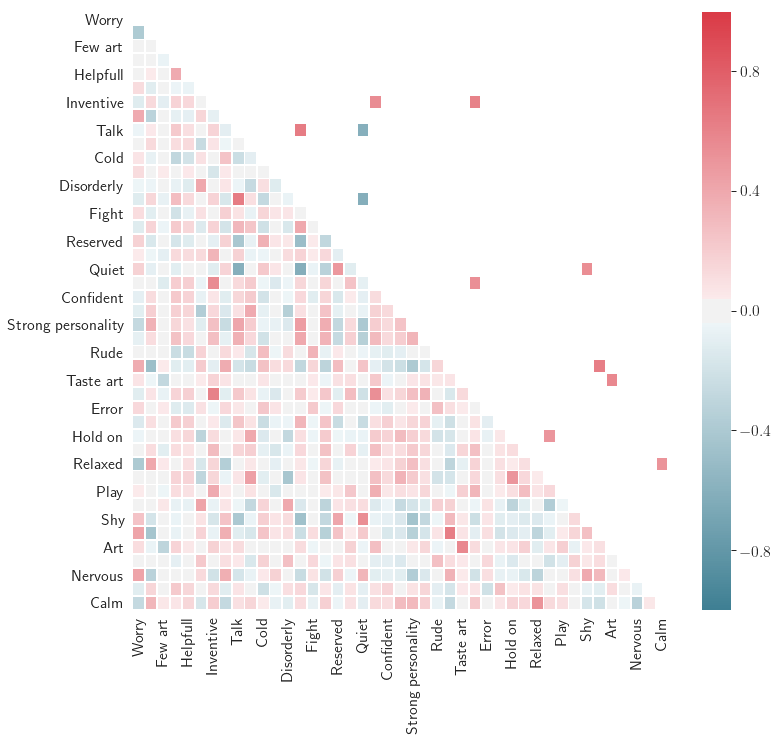

In [164]:
# mpl.rcParams['text.usetex'] = False
# mpl.rcParams['text.latex.unicode'] = False

def plotCrossCorr(df, threshold=None):
    
    df = df.copy() 
    corr = df.corr()
    corrval = corr.values
    mask = np.eye(*corr.shape)
    if threshold is None:
        mask[np.triu_indices_from(mask)] = 1
    else:
        mask[np.triu_indices_from(mask, k=1)] = np.abs(corrval[np.triu_indices_from(mask, k=1)]) < threshold
    fig, ax = plt.subplots(figsize=(12, 11))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    # cmap = mpl.cm.RdBu_r
    sns.heatmap(corr, vmin=-1, vmax=1, cmap=cmap, mask=mask, linewidths=0.8, ax=ax)
    return fig, ax, corrval

fig, ax, corrval = plotCrossCorr(df_temp, threshold=0.5);
fig.savefig('figs/data_cross_correlation.pdf')


class LargestElements:
    """Container for n absolute largest elements"""
    def __init__(self, n):
        self.n = n
        self.absdct = dict()

    def add(self, val, i, j):
        absval = np.abs(val)
        keys = self.absdct.keys()
        if len(self.absdct) < self.n or absval > min(keys):
            self.absdct[absval] = (val, i, j)
        if len(self.absdct) > self.n:
            del self.absdct[min(keys)]

    def get(self):
        return self.absdct


def max_abs_n_idx_triu(arr, n):
    le = LargestElements(n)
    for i in range(arr.shape[0]):
        for j in range(i):
            if i == j:
                continue
            le.add(arr[i, j], i, j)
    return le.get()


max_abs_n_idx_triu(corrval, 4)

In [165]:
del df_temp

## Logistic regression on the raw data

In [22]:
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.unicode'] = True

Due to class imbalance, use a balanced weight function.

In [23]:
lr = linear_model.LogisticRegressionCV(penalty='l2', scoring=roc_auc_weighted)
lr.fit(df1.values, gender.values)
prob1 = lr.predict_proba(df1.values)[:, 1]

print("Unbalanced cost function")
print("Regularization coefficient C: ", lr.C_[0])
print("accuracy_score:", accuracy_score(gender.values, prob1>0.5))
print("roc_auc_score:", roc_auc_score(gender.values, prob1))
print("confusion_matrix:\n", confusion_matrix(gender.values, prob1>0.5)) 

Unbalanced cost function
Regularization coefficient C:  2.782559402207126
accuracy_score: 0.8351063829787234
roc_auc_score: 0.8471085858585858
confusion_matrix:
 [[684  36]
 [119 101]]


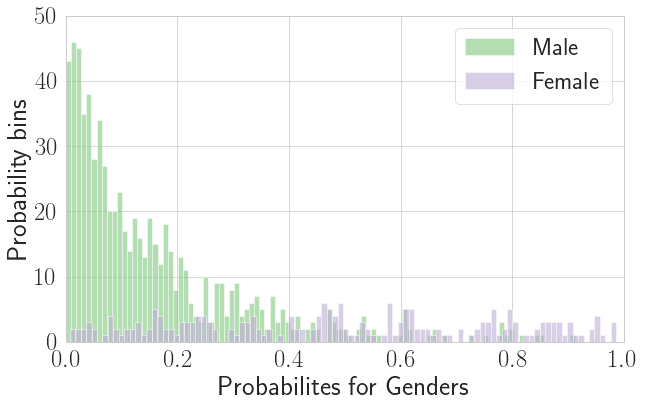

In [24]:
gmsk = gender.values.astype(bool)

fig, ax = plt.subplots()
hist_params = dict(bins=100, alpha=0.6)
ax.hist(prob1[~gmsk], label="Male", **hist_params) 
ax.hist(prob1[gmsk], label="Female", **hist_params)
ax.set_xlabel("Probabilites for Genders")
ax.set_ylabel("Probability bins")
# ax.set_ylabel("Count")
ax.legend(loc="upper right")
ax.set_xlim([0, 1])  
ax.set_ylim([0, 50]) 
fig.savefig("figs/lr_unbalanced_sex_prediction_probability_distribution_histogram_gender_separated.pdf")

In [25]:
fpr, tpr, threshold = metrics.roc_curve(gender.values, prob1) 

In [26]:
metrics.auc(fpr, tpr)

0.8471085858585858

AUC: 0.8471085858585858


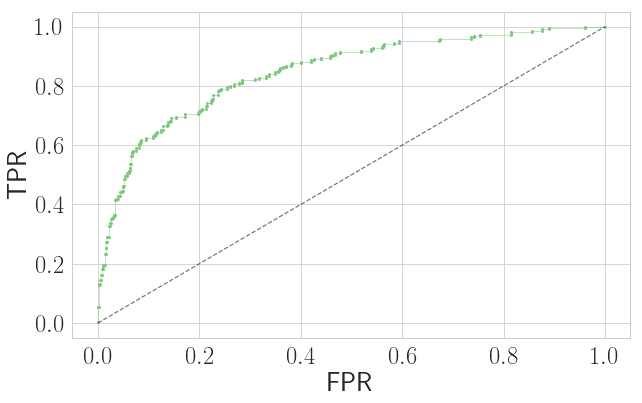

In [27]:
rocdata_lr_unbalanced = (gender.values, prob1)
fig, ax, aucscore = plotting.plotROC(gender.values, prob1, xy_guide=True)
fig.savefig('figs/sex_prediction_raw_data.pdf')

Extract underlying linear line fit parameters

In [28]:
lr_raw_coef = modeleval.lr_uncertainty(df1.values, lr)
lr_raw_coef.head() 

,coeff,stderr
X0,0.643544,1.268695
X1,0.154561,0.106896
X2,-0.415474,0.114280
X3,-0.185343,0.087836
X4,0.415472,0.172631


In [29]:
with open('lr_raw_data.pkl', 'bw') as fid:
    pickle.dump(lr, fid) 

In [30]:
print("Balanced cost function, relative to occurence of classes")
lr = linear_model.LogisticRegressionCV(penalty='l2', scoring=roc_auc_weighted, class_weight='balanced')
lr.fit(df1.values, gender.values)
prob1 = lr.predict_proba(df1.values)[:, 1]

print("Regularization coefficient C: ", lr.C_[0]) 
print("accuracy_score:", accuracy_score(gender.values, prob1>0.5))
print("roc_auc_score:", roc_auc_score(gender.values, prob1))
print("confusion_matrix:\n", confusion_matrix(gender.values, prob1>0.5)) 

Balanced cost function, relative to occurence of classes
Regularization coefficient C:  0.005994842503189409
accuracy_score: 0.7553191489361702
roc_auc_score: 0.8404924242424243
confusion_matrix:
 [[545 175]
 [ 55 165]]


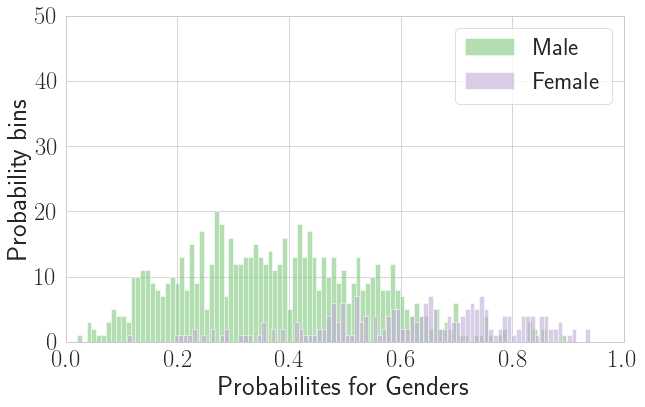

In [31]:
gmsk = gender.values.astype(bool)

fig, ax = plt.subplots()
hist_params = dict(bins=100, alpha=0.6)
ax.hist(prob1[~gmsk], label="Male", **hist_params) 
ax.hist(prob1[gmsk], label="Female", **hist_params)
ax.set_xlabel("Probabilites for Genders")
ax.set_ylabel("Probability bins")
# ax.set_ylabel("Count")
ax.legend(loc="upper right")
ax.set_xlim([0, 1]) 
ax.set_ylim([0, 50]) 
fig.savefig("figs/lr_balanced_sex_prediction_probability_distribution_histogram_gender_separated.pdf")

AUC: 0.8404924242424243


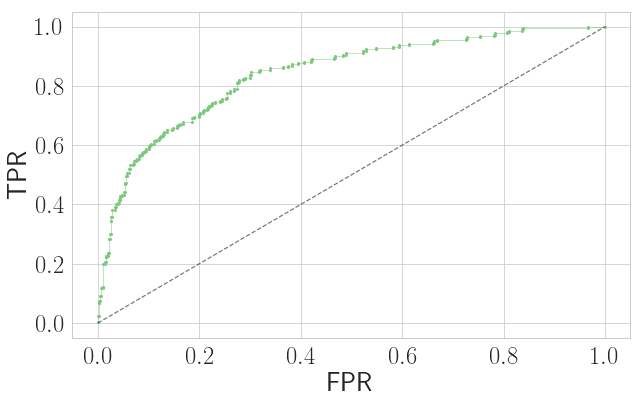

In [32]:
rocdata_lr_balanced = (gender.values, prob1)
fig, ax, aucscore = plotting.plotROC(gender.values, prob1, xy_guide=True)
fig.savefig('figs/sex_prediction_raw_balanced_data.pdf')

In [33]:
lr_balanced_coef = modeleval.lr_uncertainty(df1.values, lr)
lr_balanced_coef.head() 

,coeff,stderr
X0,1.069497,0.968580
X1,0.143378,0.079831
X2,-0.209985,0.087711
X3,-0.103290,0.067513
X4,0.122662,0.122655


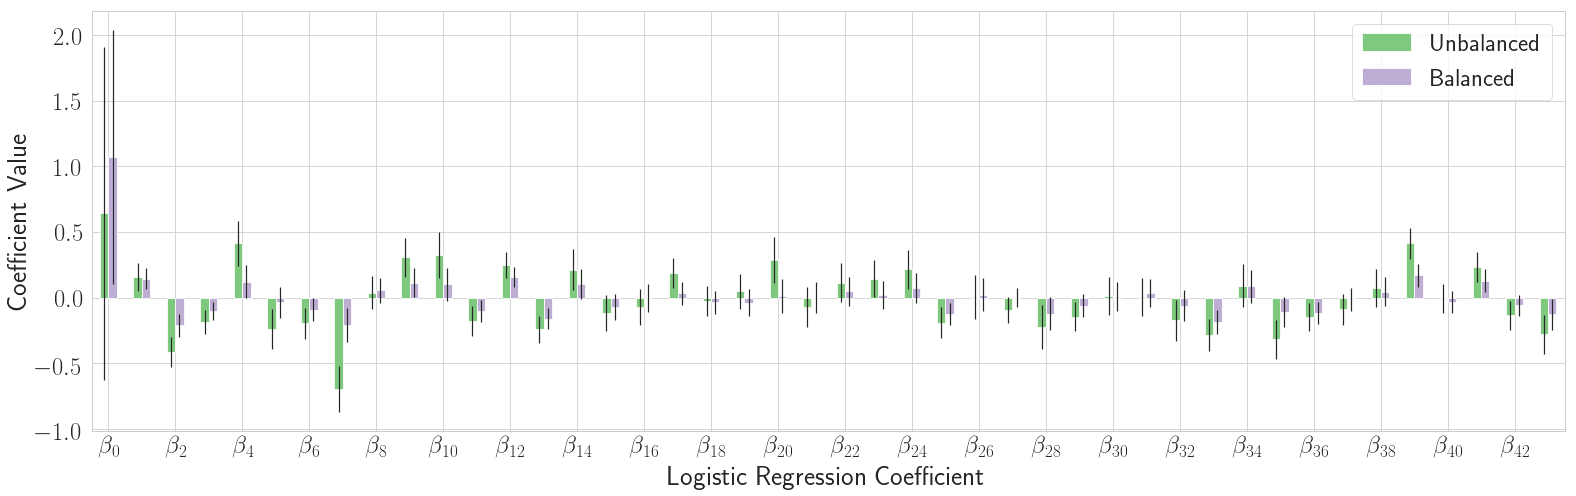

In [36]:
fig, ax = plt.subplots(figsize=(22, 7))
tmp = lr_join_coef.reset_index(drop=True).rename(columns={"coeff raw": "Unbalanced",
                                                          "coeff balanced": "Balanced",
                                                          "stderr raw": "s_unb",
                                                          "stderr balanced": "s_bal"})
tmp[["Unbalanced", "Balanced"]].plot(kind='bar', yerr=lr_join_coef[["stderr raw", "stderr balanced"]].values.T,
                                                   ax=ax) 
ax.set_xticks(np.arange(0, 44, 2))
ax.set_xticklabels([r"$\beta_{%d}$" % i for i in ax.get_xticks()], rotation='horizontal')
ax.set_xlabel("Logistic Regression Coefficient")
ax.set_ylabel("Coefficient Value")
fig.tight_layout() 
fig.savefig("figs/lr_coefficients_bar.pdf")

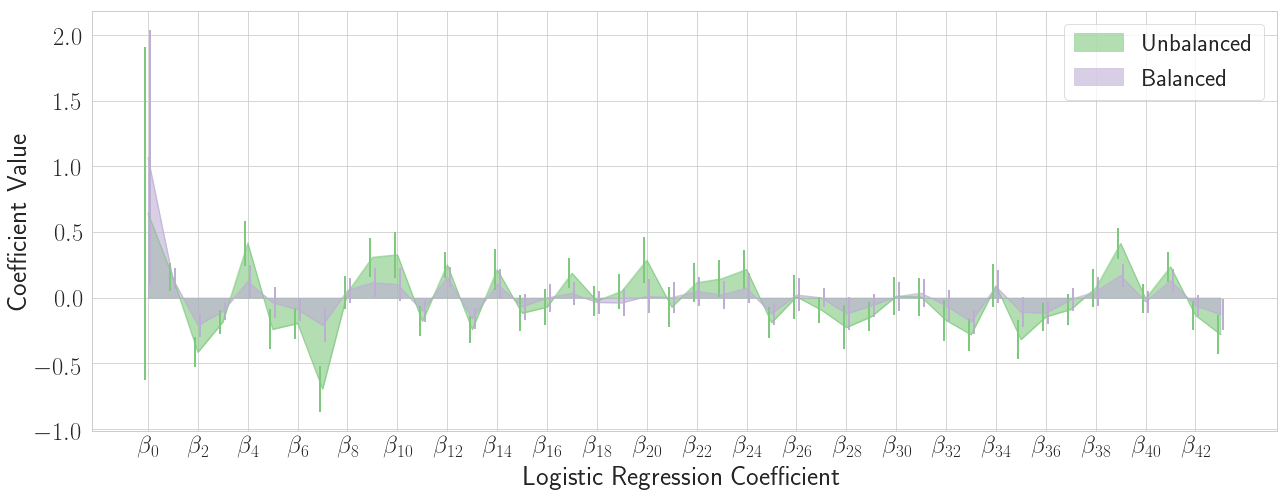

In [37]:
fig, ax = plt.subplots(figsize=(18, 7))
tmp[["Unbalanced", "Balanced"]].plot(kind='area', alpha=0.6, stacked=False, ax=ax)
ax.errorbar(np.arange(tmp.Balanced.shape[0])+0.1, tmp.Balanced, tmp.s_bal, fmt='none',
            elinewidth=2, label=None, color=colorcycle[1])
ax.errorbar(np.arange(tmp.Unbalanced.shape[0])-0.1, tmp.Unbalanced, tmp.s_unb, fmt='none',
            elinewidth=2, label=None, color=colorcycle[0])
ax.set_xticks(np.arange(0, 44, 2))
ax.set_xticklabels([r"$\beta_{%d}$" % i for i in ax.get_xticks()], rotation='horizontal');
ax.set_xlabel("Logistic Regression Coefficient")
ax.set_ylabel("Coefficient Value")
fig.tight_layout() 
fig.savefig("figs/lr_coefficients_area.pdf")
del tmp

Try with weighted classes, but the take the square root of the weights (all weights > 1 is True)

Save the model for producing error estimates

In [39]:
with open('lr_balanced_raw_data.pkl', 'bw') as fid:
    pickle.dump(lr, fid)

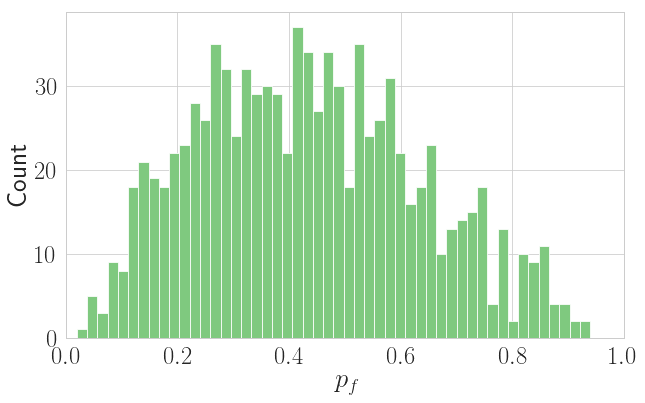

In [40]:
fig, ax = plt.subplots()
ax.hist(prob1, bins=50)
ax.set_xlabel('$p_f$')
ax.set_ylabel('Count')
ax.set_xlim([0, 1]) 
fig.savefig('figs/sex_prediction_raw_data_prob1_vs_count.pdf')

## More ROC-curves 

Oversamlling the dataset.

In [ ]:
n_iter = 40

In [174]:
def oversampling_lr(X_org, y_org, n_iter, ax, auc_do=print):    
    auc_score_arr = -1*np.ones(n_iter)
    acc_score_arr = -1*np.ones(n_iter)
    C_arr = -1*np.ones(n_iter)
    coef = list()
    for i in range(n_iter):
        ros = over_sampling.RandomOverSampler()
        X, y = ros.fit_resample(X_org, y_org)
        lr = linear_model.LogisticRegressionCV() 
        lr.fit(X, y)
        coef.append(lr.coef_.copy())
        prob1 = lr.predict_proba(X_org)[:, 1] 
        plotting.plotROC(y_org, prob1, xy_guide=True, ax=ax, color=colorcycle[0], alpha=1/n_iter, auc_do=auc_do)
        auc_score_arr[i] = metrics.roc_auc_score(y_org, prob1) 
        acc_score_arr[i] = metrics.accuracy_score(y_org, prob1 > 0.5)
        C_arr[i] = lr.C_
    print(f"Mean AUC: {auc_score_arr.mean()} +/- { auc_score_arr.std()}") 
    print(f"Mean accuracy: {acc_score_arr.mean()} +/- { acc_score_arr.std()}") 
    return auc_score_arr, acc_score_arr, coef, C_arr

On the first 7 PCA components

AUC: 0.8248989898989899
AUC: 0.825574494949495
AUC: 0.8236363636363637
AUC: 0.8263068181818182
AUC: 0.8242424242424242
AUC: 0.8261300505050505
AUC: 0.8246527777777778
AUC: 0.8245012626262627
AUC: 0.8254040404040404
AUC: 0.8246527777777777
AUC: 0.8248989898989899
AUC: 0.8258459595959596
AUC: 0.8249747474747474
AUC: 0.8233207070707071
AUC: 0.8241792929292928
AUC: 0.8248042929292928
AUC: 0.8228472222222223
AUC: 0.8245833333333333
AUC: 0.8237752525252526
AUC: 0.8261868686868687
Mean AUC: 0.8247708333333333 +/- 0.0009310297761687424
Mean accuracy: 0.753404255319149 +/- 0.004858803083689029


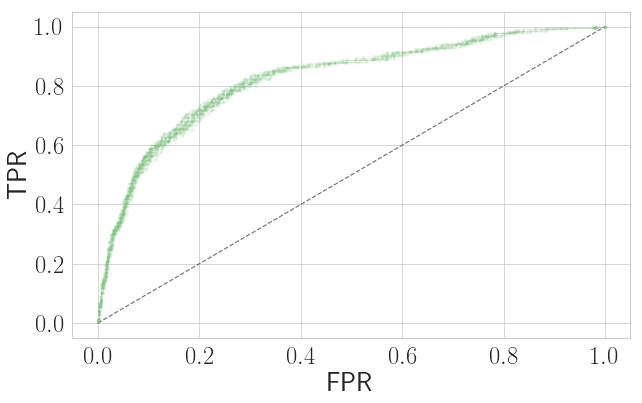

In [175]:
fig, ax = plt.subplots()
auc_scores, acc_scores, coef, C = oversampling_lr(td1[:, :7], gender.values, n_iter, ax)

On the entire dataset, oversampled

Mean AUC: 0.8439527462121211 +/- 0.0029238220758813264
Mean accuracy: 0.7650531914893617 +/- 0.007616419505528893


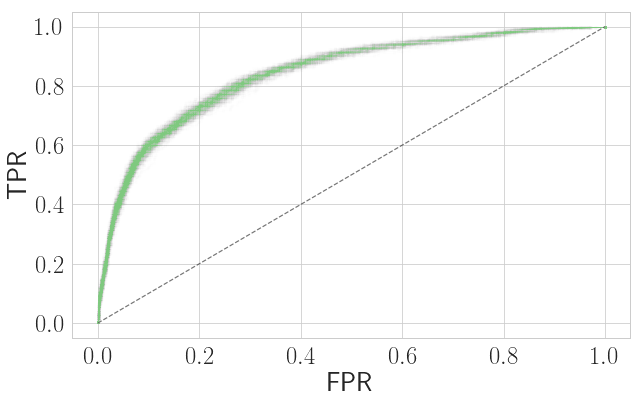

In [205]:
fig, ax = plt.subplots()
auc_scores, acc_scores, coef, C = oversampling_lr(df1.values, gender.values, 200, ax, auc_do=None)
fig.savefig("figs/random_oversampling_lr_full_data.pdf")
fig.savefig("figs/random_oversampling_lr_full_data.png", dpi=400)

Produce uncertainties for the model, based on the median values of the coefficients

In [187]:
lr = linear_model.LogisticRegression()
lr.fit(df1.values, gender.values)
lr.coef_ = np.median(np.stack(coef, axis=2), axis=2) 
lr.C_ = np.median(C)

rocdata_lr_oversampled = (gender.values, prob1)

print("AUC:", metrics.roc_auc_score(*rocdata_lr_oversampled))

lr_oversamepled_coef = modeleval.lr_uncertainty(df1.values, lr) 
lr_balanced_coef.head() 



AUC: 0.8477967171717173


,coeff,stderr
X0,1.069497,0.968580
X1,0.143378,0.079831
X2,-0.209985,0.087711
X3,-0.103290,0.067513
X4,0.122662,0.122655


In [206]:
np.std(np.stack(coef, axis=2), axis=2)

array([[0.03205858, 0.09034084, 0.03904806, 0.11059597, 0.07315372,
        0.05618928, 0.16841809, 0.03878512, 0.06717391, 0.09522939,
        0.04673048, 0.05287569, 0.04791488, 0.06892422, 0.05253619,
        0.05725335, 0.06249442, 0.04165745, 0.03895385, 0.09230053,
        0.05642691, 0.03989999, 0.06840399, 0.0862722 , 0.05662225,
        0.05347444, 0.03229972, 0.06516147, 0.04952829, 0.04351644,
        0.05992473, 0.05960437, 0.0403417 , 0.06295756, 0.06699981,
        0.03550572, 0.04653445, 0.04225869, 0.0733918 , 0.03884069,
        0.04988173, 0.04421375, 0.076329  ]])

In [201]:

lr_join_coef = lr_raw_coef.join(lr_balanced_coef, lsuffix=' raw', rsuffix=' balanced')
lr_join_coef = lr_join_coef.join(lr_oversamepled_coef, rsuffix=' oversampled')
lr_join_coef = lr_join_coef.rename(columns={"coeff": "coeff oversampled", "stderr": "stderr oversampled"})
lr_join_coef.head() 
# Print coefficients as a LaTeX table. Uncommmented because it takes a lot of space in the notebook
# print(lr_join_coef.to_latex(float_format='%.3f'))

,coeff raw,stderr raw,coeff balanced,stderr balanced,coeff oversampled,stderr oversampled
X0,0.643544,1.268695,1.069497,0.968580,0.243768,1.311750
X1,0.154561,0.106896,0.143378,0.079831,0.164940,0.112251
X2,-0.415474,0.114280,-0.209985,0.087711,-0.399168,0.118251
X3,-0.185343,0.087836,-0.103290,0.067513,-0.148860,0.090612
X4,0.415472,0.172631,0.122662,0.122655,0.268782,0.179064


On the entire PCA dataset

AUC: 0.8436553030303031
AUC: 0.8471717171717172
AUC: 0.8456060606060607
AUC: 0.8345454545454545
AUC: 0.8434785353535353
AUC: 0.8441856060606061
AUC: 0.843270202020202
AUC: 0.8418181818181818
AUC: 0.8425315656565657
AUC: 0.8438068181818182
AUC: 0.8450568181818183
AUC: 0.8444696969696968
AUC: 0.8295012626262626
AUC: 0.8340025252525252
AUC: 0.8471022727272728
AUC: 0.8422285353535354
AUC: 0.8339772727272726
AUC: 0.8447348484848485
AUC: 0.8449684343434344
AUC: 0.8440025252525253
Mean AUC: 0.8420056818181818 +/- 0.004778016224336398
Mean accuracy: 0.765691489361702 +/- 0.007881499846921911


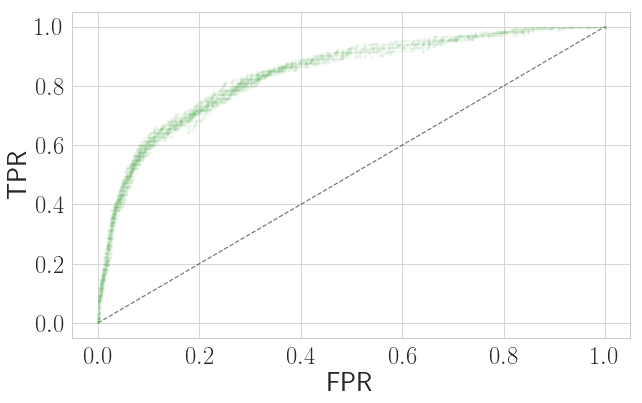

In [176]:
fig, ax = plt.subplots()
auc_scores, acc_scores, coef, C = oversampling_lr(td1, gender.values, n_iter, ax) 

AUC: 0.8471085858585858
AUC: 0.8404924242424243
AUC: 0.8477967171717173


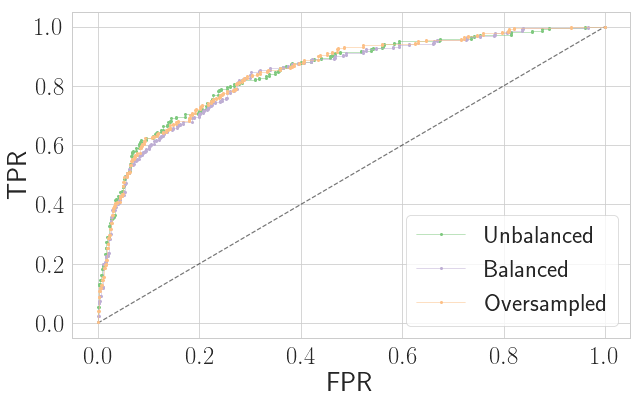

In [204]:
fig, ax = plt.subplots()
plotting.plotROC(*rocdata_lr_unbalanced, label="Unbalanced", xy_guide=True, ax=ax)
plotting.plotROC(*rocdata_lr_balanced, label="Balanced", ax=ax)
plotting.plotROC(*rocdata_lr_oversampled, label="Oversampled", ax=ax)
ax.legend() 
fig.savefig("figs/lr_roc_balanced_unbalanced_oversampled.pdf")

## Logistic regression on the _expanded_ raw data

Expand the data with products accross _all_ variables

In [41]:
idx = np.arange(df1.values.shape[1]).astype(int)  
idxCombinations = list(itertools.product(idx, idx))
featureMatrix = np.NaN * np.zeros((df1.values.shape[0], df1.values.shape[1]+len(idxCombinations)))

In [42]:
featureMatrix[:, :df1.values.shape[1]] = df1.values.copy() 

In [43]:
for i, (v0, v1) in enumerate(idxCombinations, df1.values.shape[1]):
    featureMatrix[:, i] = featureMatrix[:, v0] * featureMatrix[:, v1]

In [44]:
lre = linear_model.LogisticRegression()
lre.fit(featureMatrix, gender.values)
prob1 = lre.predict_proba(featureMatrix)[:, 1]

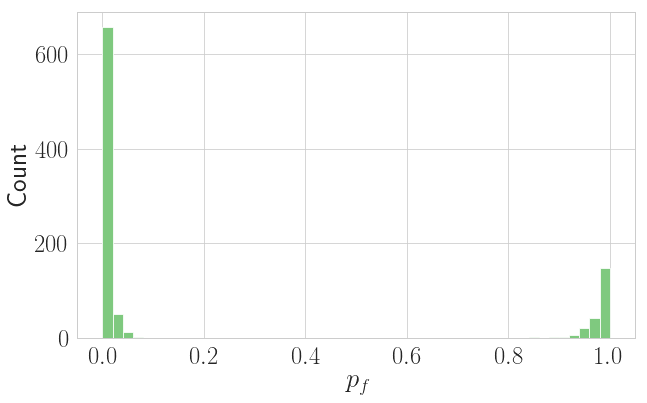

In [45]:
fig, ax = plt.subplots()
ax.hist(prob1, bins=50)
ax.set_xlabel('$p_f$')
ax.set_ylabel('Count')
fig.savefig('figs/sex_prediction_expanded_data_prob1_vs_count.pdf')

In [46]:
accuracy_score(gender.values, prob1>0.5) 

1.0

AUC: 1.0


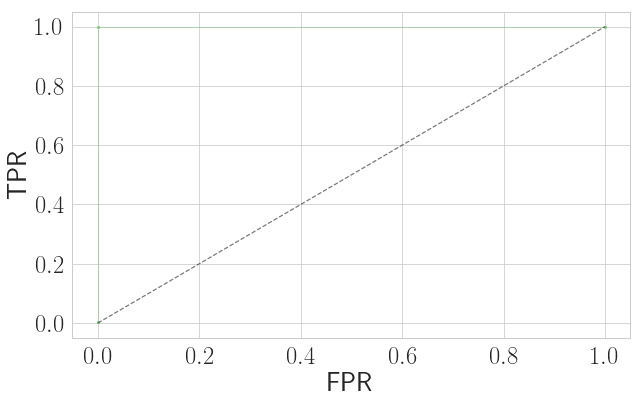

In [47]:
fig, ax, aucscore = plotting.plotROC(gender.values, prob1, xy_guide=True)
fig.savefig('figs/sex_prediction_expanded_data.pdf')

Problem is overdeterminded (n_rows < n_columns).

Reduce the problem using PCA.

In [48]:
pca = decomposition.PCA(n_components=featureMatrix.shape[0]//4)
featureMatrix_pca = pca.fit_transform(featureMatrix) 

In [49]:
lre = linear_model.LogisticRegressionCV(scoring=roc_auc_weighted)
lre.fit(featureMatrix_pca, gender.values)
prob1 = lre.predict_proba(featureMatrix_pca)[:, 1]

Text(0,0.5,'Count')

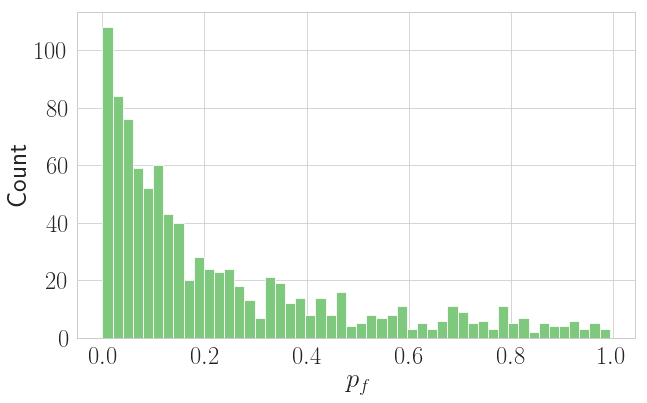

In [50]:
fig, ax = plt.subplots()
ax.hist(prob1, bins=50)
ax.set_xlabel('$p_f$')
ax.set_ylabel('Count')
# fig.savefig('figs/sex_prediction_expanded_data_prob1_vs_count.pdf')

AUC: 0.8954419191919192


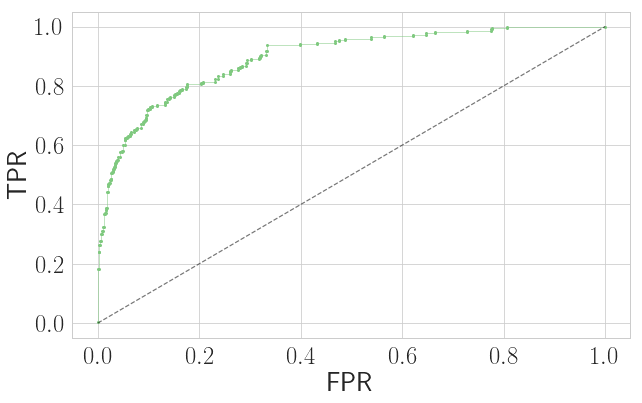

In [51]:
fig, ax, aucscore = plotting.plotROC(gender.values, prob1, xy_guide=True)
# fig.savefig('figs/sex_prediction_raw_data.pdf')

Try using a validation set

AUC: 0.8093167701863355


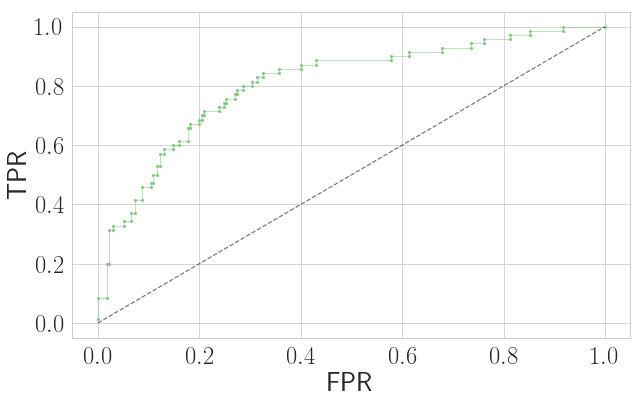

In [52]:
pca = decomposition.PCA(n_components=36)

fm1 = featureMatrix[:-300, :] 
ym1 = gender.values[:-300] 
fm2 = featureMatrix[-300:, :] 
ym2 = gender.values[-300:] 

fm1 = pca.fit_transform(fm1) 
fm2 = pca.transform(fm2)

fm1.shape
ym1.shape

lre.fit(fm1, ym1)

val_prob1 = lre.predict_proba(fm2)[:, 1] 

fig, ax, aucscore = plotting.plotROC(ym2, val_prob1, xy_guide=True) 

It fares no better

In [53]:
with open("../../allan_data/joachim_exercise_pca_lr.pkl", 'bw') as fid:
    pickle.dump((pca, featureMatrix_pca, lre), fid)

AUC: 0.8955176767676767


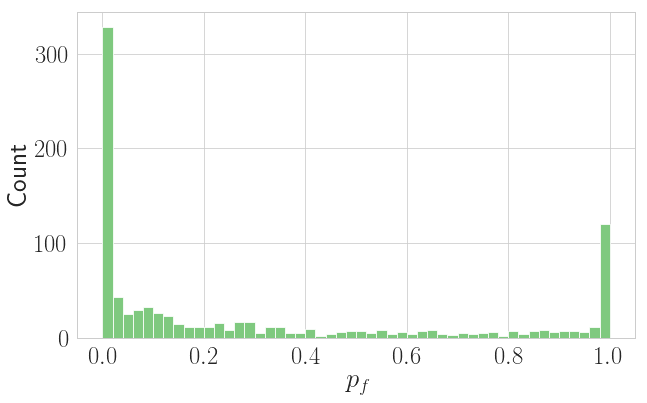

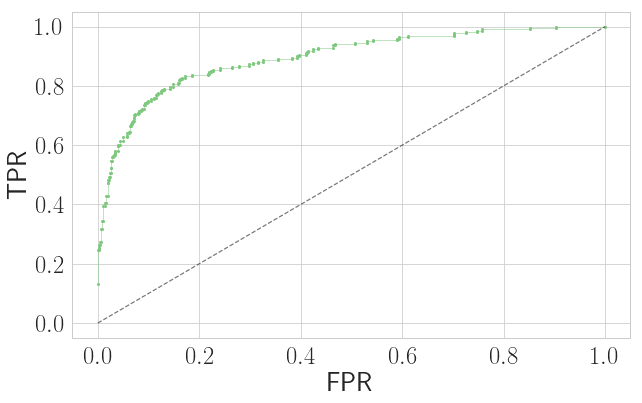

In [54]:
kpca = decomposition.KernelPCA(n_components=featureMatrix.shape[0]//4, kernel='poly',
                               degree=4, remove_zero_eig=True) 
featureMatrix_kpca = kpca.fit_transform(featureMatrix)

lre = linear_model.LogisticRegressionCV(scoring=roc_auc_weighted)
lre.fit(featureMatrix_kpca, gender.values)
prob1 = lre.predict_proba(featureMatrix_kpca)[:, 1]

fig, ax = plt.subplots() 
ax.hist(prob1, bins=50)
ax.set_xlabel('$p_f$')
ax.set_ylabel('Count')
# fig.savefig('figs/sex_prediction_expanded_data_prob1_vs_count.pdf')

fig, ax, aucscore = plotting.plotROC(gender.values, prob1, xy_guide=True)
# fig.savefig('figs/sex_prediction_raw_data.pdf') 

In [55]:
with open("../../allan_data/joachim_exercise_kpca_lr.pkl", 'bw') as fid:
    pickle.dump((kpca, featureMatrix_kpca, lre), fid)

Expanding the data feature spacce / predictor space using using simple cross products of all variables, and subsequently reducing the dataset using a PCA or kernel-PCA for dimmensionality reduction to a ensure that the problemer aren't overdeterminded, seems like a good strategy.
It should definently be done rigourously using proper cross validation!

### Perform PCA 

In [56]:
nd1 = scale(df1.values)
pca = decomposition.PCA(svd_solver='full') 
pca.fit(nd1)

/lscr_paper/allan/miniconda3/envs/py36up/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='full', tol=0.0, whiten=False)

Text(0.5,1,'Eigenvalues accumulated')

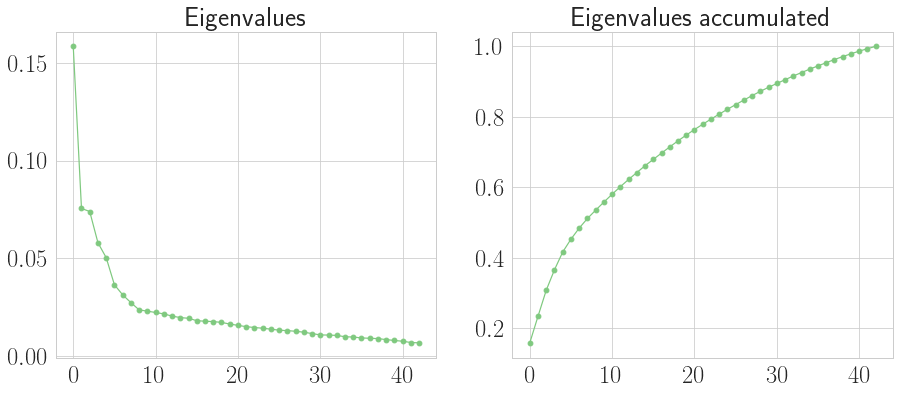

In [57]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 6)) 
ax0.plot(pca.explained_variance_ratio_, 'o-')
ax1.plot(np.cumsum(pca.explained_variance_ratio_), 'o-')
ax0.set_title('Eigenvalues')
ax1.set_title('Eigenvalues accumulated')

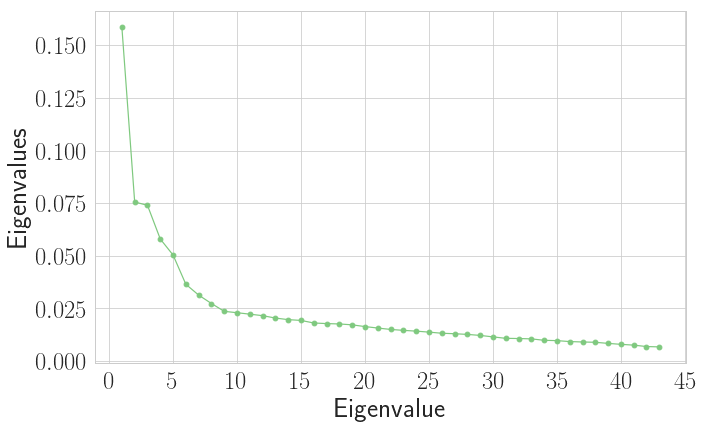

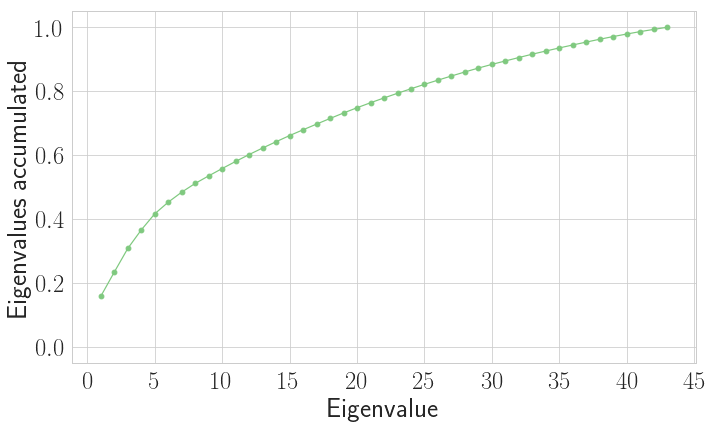

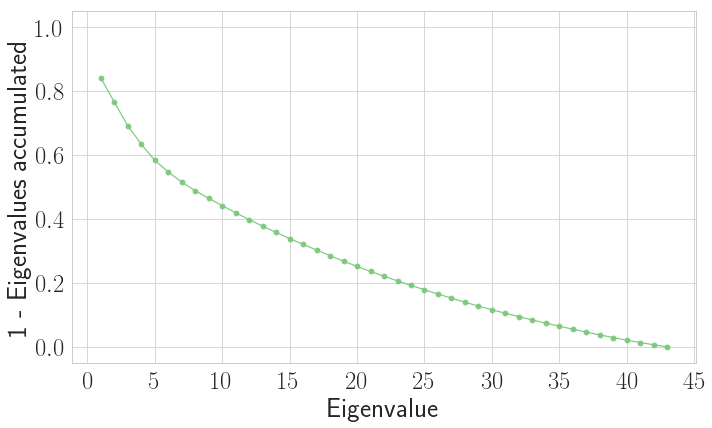

In [58]:
# For saving output

fig, ax = plt.subplots() 
ax.plot(np.arange(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, 'o-')
ax.set_xlabel('Eigenvalue #')
ax.set_ylabel('Eigenvalues')
ax.set_xticks(np.arange(0, 46, 5))
plt.tight_layout() 
fig.subplots_adjust(left=0.15, bottom=0.15)
fig.savefig('figs/pca_eigenvalues.pdf')

fig, ax = plt.subplots()
ax.plot(np.arange(1, len(pca.explained_variance_ratio_)+1), np.cumsum(pca.explained_variance_ratio_), 'o-')
ax.set_xlabel('Eigenvalue #')
ax.set_ylabel('Eigenvalues accumulated')
ax.set_xticks(np.arange(0, 46, 5))
plt.tight_layout() 
ax.set_ylim([-0.05, 1.05])
fig.subplots_adjust(bottom=0.15)
fig.savefig('figs/pca_eigenvalues_accumulated.pdf')

fig, ax = plt.subplots()
ax.plot(np.arange(1, len(pca.explained_variance_ratio_)+1), 1 - np.cumsum(pca.explained_variance_ratio_), 'o-')
ax.set_xlabel('Eigenvalue #')
ax.set_ylabel('1 - Eigenvalues accumulated')
ax.set_xticks(np.arange(0, 46, 5)) 
plt.tight_layout() 
ax.set_ylim([-0.05, 1.05]) 
fig.subplots_adjust(bottom=0.15)
fig.savefig('figs/pca_eigenvalues_scree.pdf')

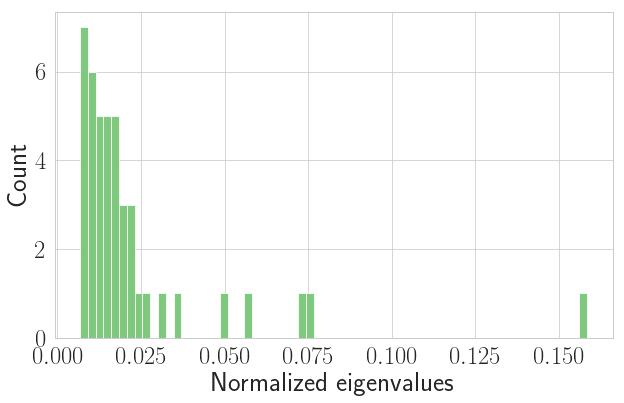

In [59]:
fig, ax = plt.subplots()
ax.hist(pca.explained_variance_ratio_, bins=65);
ax.set_xlabel('Normalized eigenvalues')
ax.set_ylabel('Count')
fig.savefig('figs/pca_eigenvalues_histogram.pdf')

In [60]:
td1 = pca.transform(nd1)  # The rotated vector space

In [61]:
td1[:, 0].std() 

2.6110289430470286

In [373]:
td1.shape

(940, 43)

In [374]:
td1[0, :]

array([-2.19641937, -1.03082044,  4.17571265, -2.81660883,  0.97605846,
       -0.69470062, -0.54247447,  1.32476581, -1.32540257,  1.14641027,
        0.24803062,  2.87278593, -0.2158852 ,  0.33599238,  1.32342735,
       -0.21672217, -0.73980911, -2.34796089,  2.18566218,  0.38994065,
       -0.20405752,  1.07815522, -1.04322253,  1.58684831,  1.25958581,
       -0.31772547, -0.13609862, -0.2708887 , -0.42193686,  0.78868448,
       -1.03114661,  1.30724575,  0.13794711,  0.33258815, -1.08081977,
        0.73522949,  0.92194726, -0.06186103, -0.44397312, -0.06544148,
        0.4967489 ,  0.62681943,  0.15398389])

In [375]:
td1.shape

(940, 43)

### Logistic Regression

Try the prediction with a different number of leading vectors, and plot the accuracy for the prediction

Balanced AUC, accuracy using 1 leading component(s) is 52.50 %, 53.83 %, C = 0.006
Balanced AUC, accuracy using 2 leading component(s) is 53.24 %, 53.51 %, C = 0.001
Balanced AUC, accuracy using 3 leading component(s) is 62.07 %, 62.45 %, C = 0.001
Balanced AUC, accuracy using 4 leading component(s) is 71.88 %, 71.91 %, C = 0.001
Balanced AUC, accuracy using 5 leading component(s) is 72.70 %, 72.45 %, C = 2.783
Balanced AUC, accuracy using 6 leading component(s) is 75.04 %, 74.57 %, C = 0.046
Balanced AUC, accuracy using 7 leading component(s) is 76.59 %, 75.74 %, C = 0.359
Balanced AUC, accuracy using 8 leading component(s) is 76.70 %, 75.43 %, C = 0.046
Balanced AUC, accuracy using 9 leading component(s) is 76.29 %, 75.53 %, C = 0.006
Balanced AUC, accuracy using 10 leading component(s) is 77.10 %, 76.28 %, C = 0.046
Balanced AUC, accuracy using 11 leading component(s) is 76.77 %, 75.53 %, C = 0.006
Balanced AUC, accuracy using 12 leading component(s) is 76.91 %, 75.74 %, C = 0.006
U

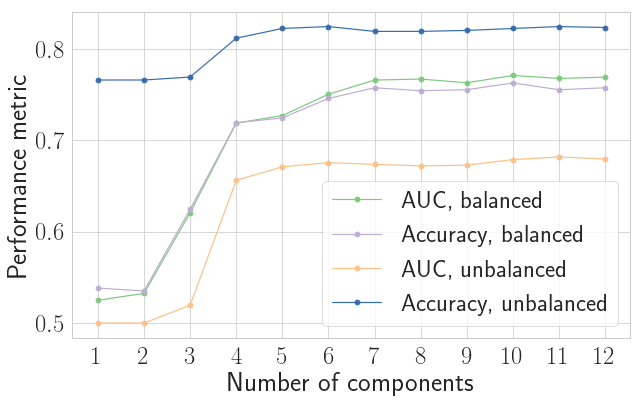

In [65]:
k_max = 12
res_acc = np.zeros((k_max, 2)) - 1  # -1 so that it's easy to spot if an entry isn't overwritten
res_auc = np.zeros((k_max, 2)) - 1  # -1 so that it's easy to spot if an entry isn't overwritten
fig, ax = plt.subplots()
keepsies = dict()
for weight, name in [('balanced', 'balanced'), (None, 'unbalanced')]:
    for k in range(1, k_max+1):
        lr = linear_model.LogisticRegressionCV(scoring=roc_auc_weighted, class_weight=weight)
        lr.fit(td1[:, :k], gender.values)
        td1p = lr.predict(td1[:, :k]) 
        acc = accuracy_score(gender.values, td1p)
        auc = roc_auc_score(gender.values, td1p)
        if k == 7:
            keepsies[f"{k}_"] = lr.coef_.copy() 
        msg_template = "{} AUC, accuracy using {} leading component(s) is {:.2f} %, {:.2f} %, C = {:.3f}"
        print(msg_template.format(name.title(), k, auc*100, acc*100, lr.C_[0])) 
        res_acc[k-1, 0] = k
        res_acc[k-1, 1] = acc
        res_auc[k-1, 0] = k
        res_auc[k-1, 1] = auc
    ax.plot(res_auc[:, 0], res_auc[:, 1], '-o', label=f'AUC, {name}')
    ax.plot(res_acc[:, 0], res_acc[:, 1], '-o', label=f'Accuracy, {name}')
    ax.set_xlabel("Number of components")
    ax.set_ylabel("Performance metric");
    ax.set_xticks(np.arange(1, k_max+1))
    ax.legend(loc='lower right')
    fig.savefig('figs/pca_logistic_regression_vs_components.pdf')

AUC, accuracy using 1 leading component(s) is 52.36 %, 53.62 %, C = 166.810, L = L1
AUC, accuracy using 2 leading component(s) is 53.50 %, 53.19 %, C = 0.359, L = L1
AUC, accuracy using 3 leading component(s) is 61.95 %, 62.02 %, C = 2.783, L = L1
AUC, accuracy using 4 leading component(s) is 72.42 %, 70.32 %, C = 0.046, L = L1
AUC, accuracy using 5 leading component(s) is 72.86 %, 72.45 %, C = 0.359, L = L1
AUC, accuracy using 6 leading component(s) is 75.27 %, 74.68 %, C = 2.783, L = L1
AUC, accuracy using 7 leading component(s) is 76.52 %, 75.64 %, C = 0.359, L = L1
AUC, accuracy using 8 leading component(s) is 76.35 %, 74.89 %, C = 0.359, L = L1
AUC, accuracy using 9 leading component(s) is 75.95 %, 75.00 %, C = 2.783, L = L1
AUC, accuracy using 10 leading component(s) is 76.78 %, 76.28 %, C = 2.783, L = L1
AUC, accuracy using 11 leading component(s) is 76.24 %, 75.21 %, C = 2.783, L = L1
AUC, accuracy using 12 leading component(s) is 76.36 %, 75.64 %, C = 2.783, L = L1
AUC, accura

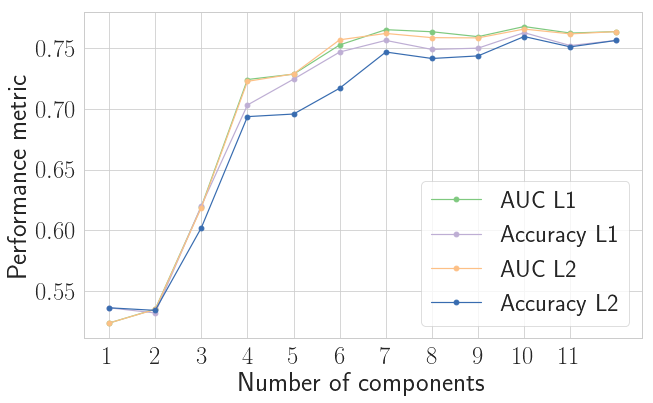

In [66]:
k_max = 12
res_acc = np.zeros((k_max, 2)) - 1  # -1 so that it's easy to spot if an entry isn't overwritten
res_auc = np.zeros((k_max, 2)) - 1  # -1 so that it's easy to spot if an entry isn't overwritten
fig, ax = plt.subplots()
keepsies = dict()
for reg in 'l1 l2'.split():
    for k in range(1, k+1):
        lr = linear_model.LogisticRegressionCV(penalty=reg, scoring=roc_auc_weighted,
                                               solver='liblinear', class_weight='balanced')
        lr.fit(td1[:, :k], gender.values)
        if k == 7:
            keepsies[f"{reg}_{k}"] = lr.coef_.copy()
        td1p = lr.predict(td1[:, :k]) 
        acc = accuracy_score(gender.values, td1p)
        auc = roc_auc_score(gender.values, td1p)
        msg_template = "AUC, accuracy using {} leading component(s) is {:.2f} %, {:.2f} %, C = {:.3f}, L = {}"
        print(msg_template.format(k, auc*100, acc*100, lr.C_[0], reg.upper()))
        res_acc[k-1, 0] = k
        res_acc[k-1, 1] = acc
        res_auc[k-1, 0] = k
        res_auc[k-1, 1] = auc
    ax.plot(res_auc[:, 0], res_auc[:, 1], '-o', label=f'AUC {reg.upper()}')
    ax.plot(res_acc[:, 0], res_acc[:, 1], '-o', label=f'Accuracy {reg.upper()}')
ax.set_xlabel("Number of components")
ax.set_ylabel("Performance metric")
# ax.set_yticks([78, 80, 82])
ax.set_xticks(np.arange(1, k_max))
ax.legend(loc="lower right")
fig.savefig('figs/pca_logistic_regression_L1_L2_vs_components.pdf') 

Fit a Logistic Regression prediction with $k = 5$ components, and plot each vector component against the gender and the prediction probability

In [67]:
k = 9
X = td1[:, :k]
lr = linear_model.LogisticRegressionCV(scoring=roc_auc_weighted, class_weight='balanced')
lr.fit(X, gender.values)
prob1 = lr.predict_proba(X)[:, 1] 

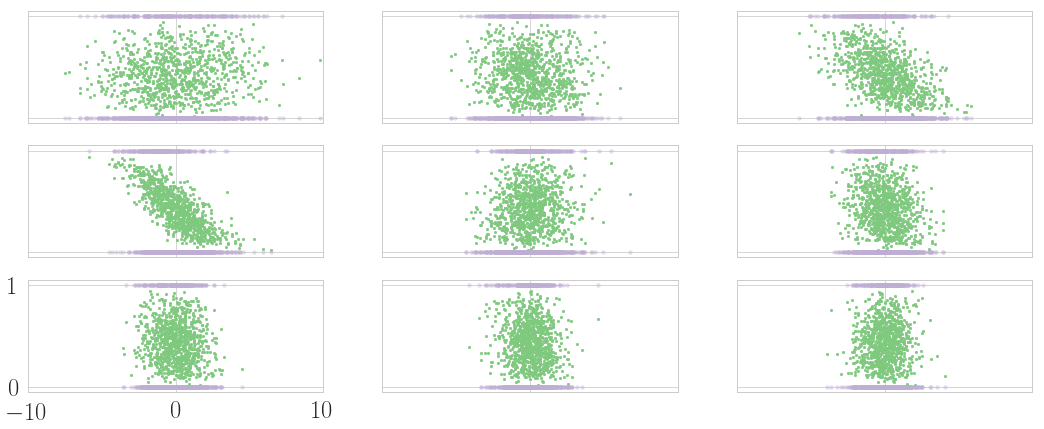

In [450]:
fig, axi = plt.subplots(3, 3, figsize=(18, 7))
axi = axi.flatten()
for i in range(k):
    axi[i].scatter(X[:, i], prob1, s=5)
    axi[i].scatter(X[:, i], gender.values, s=12, alpha=0.35)
    # axi[i].set_xlabel("Component %d" % i)
    # axi[i].set_ylabel(r"$p_f$")
    axi[i].set_ylim([-0.05, 1.05])
    axi[i].set_xlim([-10, 10])
    if i != 6:
        axi[i].set_xticklabels([])
        axi[i].set_yticklabels([])
fig.savefig(f"figs/component_{k}_with_probabilities.pdf")
fig.savefig(f"figs/component_{k}_with_probabilities.png", dpi=400)

AUC: 0.5242108585858586
AUC: 0.5250315656565656
AUC: 0.6588952020202021
AUC: 0.7634027777777777


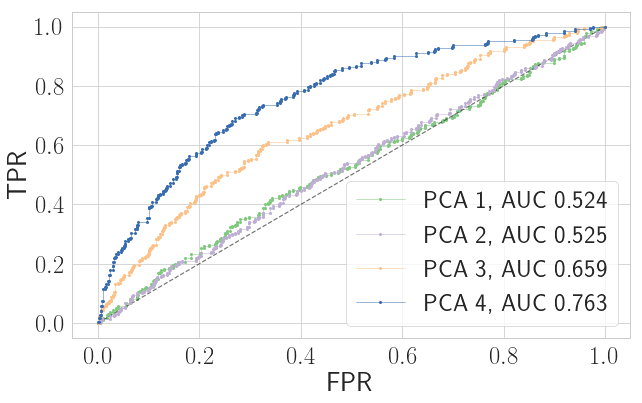

In [445]:
fig, ax = plt.subplots()

for k in [0, 1, 2, 3]:
    X = td1[:, k][:, None]  # fit using the component k
    lr = linear_model.LogisticRegressionCV(scoring=roc_auc_weighted, class_weight='balanced')
    lr.fit(X, gender.values)
    prob1 = lr.predict_proba(X)[:, 1]
    auc = metrics.roc_auc_score(gender.values, prob1)
    plotting.plotROC(gender.values, prob1, xy_guide=True, label=f"PCA {k+1}, AUC {auc:.3f}", ax=ax)
ax.legend() 
fig.savefig("figs/pca_single_component_lr.pdf")

Make the plots again, but save in indivudial files

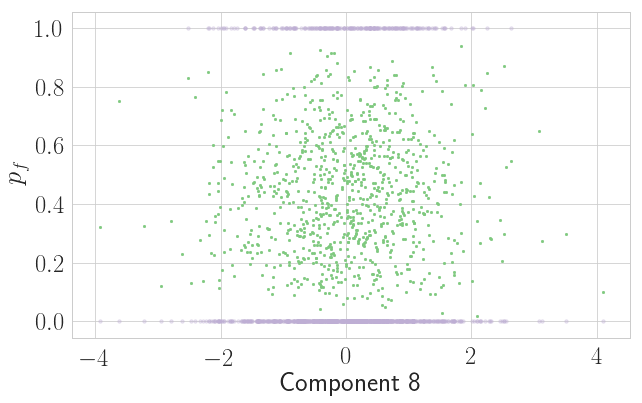

In [448]:
fig, ax = plt.subplots()
k = 9
X = td1[:, :k]
lr = linear_model.LogisticRegressionCV(scoring=roc_auc_weighted, class_weight='balanced')
lr.fit(X, gender.values)
prob1 = lr.predict_proba(X)[:, 1] 
for i in range(k):
    ax.cla() 
    ax.scatter(X[:, i], prob1, s=5)
    ax.scatter(X[:, i], gender.values, s=12, alpha=0.35)
    ax.set_xlabel("Component %d" % i)
    ax.set_ylabel(r"$p_f$")
    fig.savefig(f'figs/pca_component_{i}_vs_prob1.pdf')


Component 3 looks interesting. Check the accuracy with just that component.

More thorough examination of the components

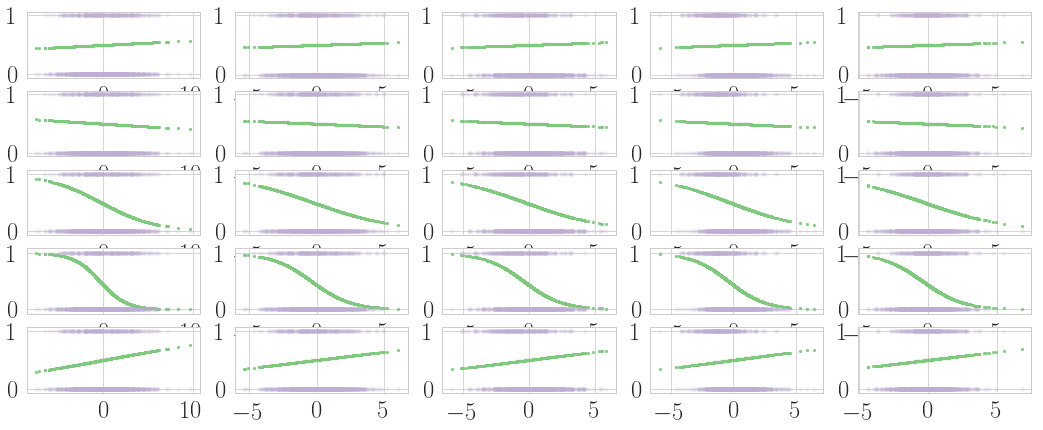

In [431]:
fig, axi = plt.subplots(5, 5, figsize=(18, 7))
axi = axi.flatten()
ac = 0
k = 5
aucmat = np.zeros((k, k))
lr2 = linear_model.LogisticRegression(solver='newton-cg', class_weight="balanced")
for i in range(k):
    X = td1[:, i][:, np.newaxis]
    lr2.fit(X, gender.values)
    for j in range(k):
        XX = td1[:, j]
        prob1 = lr2.predict_proba(XX[:, None])[:, 1]
        axi[ac].scatter(XX, prob1, s=5)
        axi[ac].scatter(XX, gender.values, s=12, alpha=0.15)
        # axi[ac].set_title(f"fit: X[:,{i}], predict: X[:,{j}]")
        ac += 1
        aucmat[i, j] = roc_auc_score(gender.values, prob1) 
fig.savefig('figs/gridplot.png', dpi=400)

### ROC curves

AUC: 0.8075189393939394


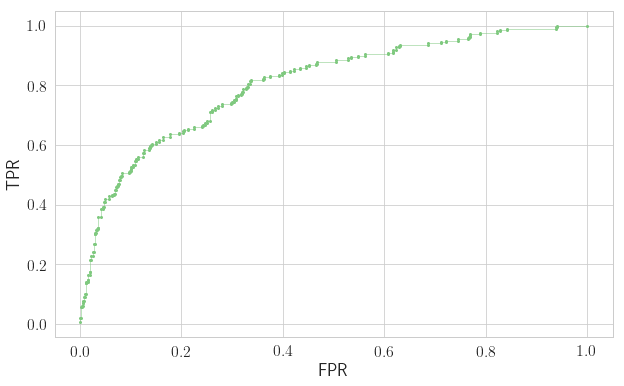

In [124]:
fig, ax, aucscore = plotting.plotROC(gender.values, lr.predict_proba(td1[:, :k])[:, 1], xy_guide=True)
fig.savefig('figs/logistic_regression_pca_roc_curve.pdf') 

### Randomly sampled components

Randomly sample $k = 5$ components 1000 times, collect the AUC-scores and plot a histogram over them.

In [286]:
k = 5
N = 5001
processes = 16
idx_lst = set() 
while len(idx_lst) < N:
    idx_lst.add(tuple(set(np.random.choice(np.arange(df1.shape[1], dtype=int), k*3)))[:k])
idx_lst = list(idx_lst)
worker_slice_idx = np.linspace(0, N-1, processes).astype(int) 

In [287]:
def lrcr(X, y, slices, weight=None):
    scores = list()
    roc_auc_weighted = metrics.make_scorer(metrics.roc_auc_score, average='weighted')
    lr = linear_model.LogisticRegressionCV(scoring=roc_auc_weighted, class_weight=weight)
    for slc in slices:
        XX = X.iloc[:, list(slc)].values
        lr.fit(XX, y)
        td1p = lr.predict(td1[:, :k]) 
        auc = metrics.roc_auc_score(y, td1p)
        scores.append(auc)
    return scores 

In [311]:
pool_args = ((df1, gender.values, idx_lst[a: b]) for (a,b) in iterutils.pairwise(worker_slice_idx))

with Pool(processes) as pool:
    auc_scores = pool.starmap(lrcr, pool_args) 

auc_scores = list(itertools.chain(*auc_scores))

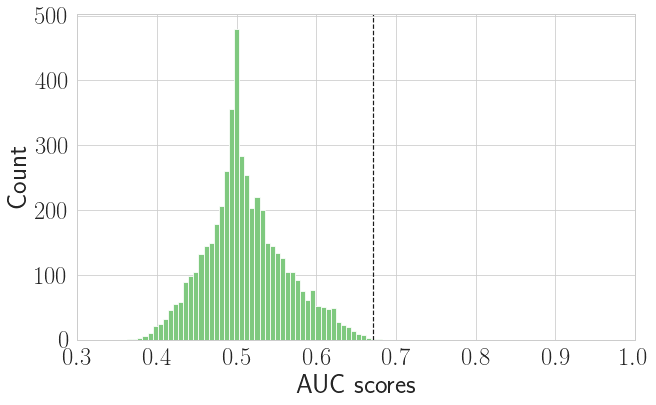

In [312]:
fig, ax = plt.subplots() 
ax.hist(auc_scores, bins=50);
ax.set_xlabel('AUC scores')
ax.set_ylabel('Count') 
ylim = ax.get_ylim() 
ax.plot([0.671, 0.671], [0, ylim[1]*1.05], '--k')
ax.set_ylim(ylim)
ax.set_xlim([0.3, 1])
fig.savefig(f'logistic_regression_auc_score_{k}_random_feature_sampling.pdf')

In [313]:
k = 7
N = 5001
processes = 16
idx_lst = set() 
while len(idx_lst) < N:
    idx_lst.add(tuple(set(np.random.choice(np.arange(df1.shape[1], dtype=int), k*3)))[:k])
idx_lst = list(idx_lst)
worker_slice_idx = np.linspace(0, N-1, processes).astype(int) 

pool_args = ((df1, gender.values, idx_lst[a: b], 'balanced') for (a,b) in iterutils.pairwise(worker_slice_idx))

with Pool(processes) as pool:
    auc_scores_weighted = pool.starmap(lrcr, pool_args) 

auc_scores_weighted = list(itertools.chain(*auc_scores_weighted)) 

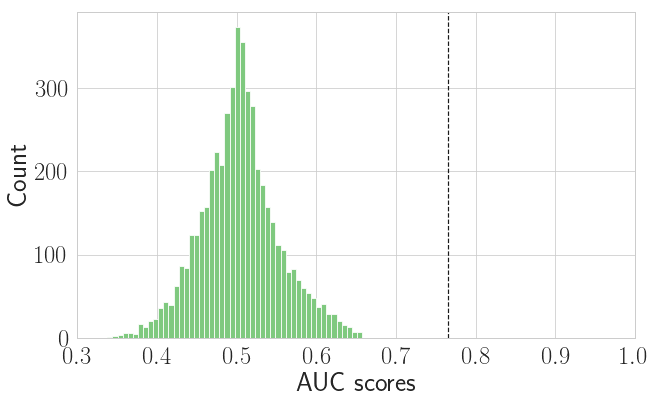

In [314]:
fig, ax = plt.subplots()
ax.hist(auc_scores_weighted, bins=50);
ax.set_xlabel('AUC scores')
ax.set_ylabel('Count')
ylim = ax.get_ylim()
ax.plot([0.7659, 0.7659], [0, ylim[1]*1.05], '--k')
ax.set_ylim(ylim)
ax.set_xlim([0.3, 1])
fig.savefig(f'logistic_regression_auc_score_{k}_random_feature_sampling.pdf') 

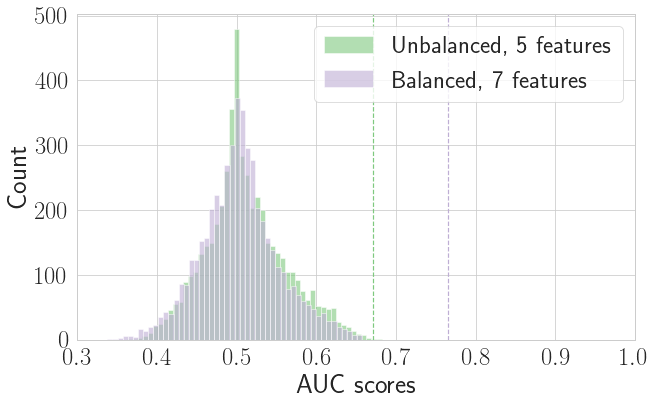

In [323]:
fig, ax = plt.subplots()
ax.hist(auc_scores, bins=50, alpha=0.6, label='Unbalanced, 5 features');
ax.hist(auc_scores_weighted, bins=50, alpha=0.6, label="Balanced, 7 features");
ax.set_xlabel('AUC scores')
ax.set_ylabel('Count')
ylim = ax.get_ylim()
ax.plot([0.671, 0.671], [0, ylim[1]*1.05], '--', color=colorcycle[0])
ax.plot([0.7659, 0.7659], [0, ylim[1]*1.05], '--', color=colorcycle[1])
ax.set_ylim(ylim)
ax.set_xlim([0.3, 1]) 
ax.legend() 
fig.savefig(f'figs/logistic_regression_auc_score_5_and_7_random_feature_sampling.pdf')

## Split data for cross validation


In [71]:
X_train, X_test, y_train, y_test = train_test_split(nd1, gender.values, test_size=0.3, stratify=gender.values)

In [72]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(658, 43) (282, 43) (658,) (282,)


### Use Linear Discriminant analysis

In [73]:
lda = discriminant_analysis.LinearDiscriminantAnalysis(store_covariance=True)

In [74]:
lda.fit(X_train, y_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=True, tol=0.0001)

In [75]:
accuracy_score(y_test, lda.predict(X_test))

0.8120567375886525

LDA didn't fare that good, but it's comparable to the SVM accuracy.

#### Also try QDA

It fares even worse, but a grid search is in order!

In [76]:
qda = discriminant_analysis.QuadraticDiscriminantAnalysis(store_covariances=True) 

In [77]:
qda.fit(X_train, y_train)

/lscr_paper/allan/miniconda3/envs/py36up/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:664: DeprecationWarning: 'store_covariances' was renamed to store_covariance in version 0.19 and will be removed in 0.21.
  DeprecationWarning)


QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariance=False, store_covariances=True, tol=0.0001)

In [78]:
accuracy_score(y_test, qda.predict(X_test))

0.7553191489361702

## Use oversamlling and undersampling methods the balance dataset

### Oversample using ADASYN

In [98]:
adasyn = over_sampling.ADASYN(sampling_strategy='minority')

In [99]:
tmp = gender.values.copy() 
tmp[tmp == 0] = -1

In [100]:
X_train, X_test, y_train, y_test = train_test_split(scale(df1.values.astype(float)), tmp,
                                                    stratify=gender.values, test_size=0.3)  

X_train, y_train = adasyn.fit_resample(X_train, y_train)

In [101]:
X_train

array([[ 0.91263283,  1.2591485 ,  0.82257943, ...,  0.18777331,
         0.19574933,  0.24342848],
       [-0.82747845,  0.31302573, -0.03181246, ...,  1.12663984,
         0.19574933,  0.24342848],
       [-0.82747845,  1.2591485 ,  0.82257943, ...,  1.12663984,
         1.21799585,  1.50764267],
       ...,
       [ 0.91263283, -0.95658308, -0.32393506, ...,  0.80563477,
        -0.82649718, -0.18881525],
       [ 0.91263283, -0.70145634,  0.02991908, ...,  0.99096982,
        -0.82649718,  0.15208644],
       [ 0.91263283, -1.64010609, -0.541483  , ...,  0.2481926 ,
        -2.3927595 , -1.69357108]])

In [102]:
lrcv = linear_model.LogisticRegressionCV(cv=5, max_iter=2500, scoring=roc_auc_weighted)

In [103]:
lrcv.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=2500,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True,
           scoring=make_scorer(roc_auc_score, average=weighted),
           solver='lbfgs', tol=0.0001, verbose=0)

In [104]:
yhat = lrcv.predict_proba(X_test)

AUC: 0.7823372615039281


(<matplotlib.figure.Figure at 0x7f1023d08940>,
 0.7823372615039281)

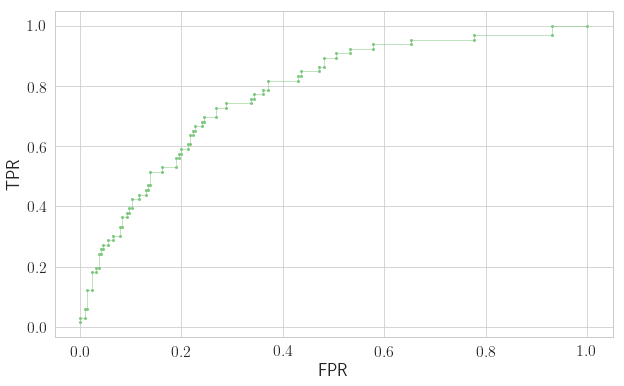

In [105]:
plotting.plotROC(y_test, yhat[:, 1])

## Try with a binarized version of the data

In [97]:
df_dummy_lst = [pd.get_dummies(df1[col], prefix=col) for col in df1.columns]
dfd = df_dummy_lst[0].copy() 
df_dummy_lst = df_dummy_lst[1:] 
dfd = dfd.join(df_dummy_lst)
del df_dummy_lst

In [98]:
dfd.shape
dfd.head() 

,worry_0,worry_1,worry_2,worry_3,worry_4,stable_0,stable_1,stable_2,stable_3,stable_4,...,forgive_0,forgive_1,forgive_2,forgive_3,forgive_4,calm_0,calm_1,calm_2,calm_3,calm_4
u1,0,0,1,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
u2,0,0,0,1,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
u3,0,0,1,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
u4,0,0,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
u5,0,0,1,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0


In [99]:
X_train, X_test, y_train, y_test = train_test_split(dfd.values, gender.values,
                                                    stratify=gender.values, test_size=0.3) 

X_train, y_train = adasyn.fit_resample(X_train, y_train) 

This runs so slowly that I was put into it's own file

convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 3 epochs took 0 seconds
convergence after 3 epochs took 0 seconds
convergence after 3 epochs took 0 seconds
convergence after 64 epochs took 1 seconds
convergence after 65 epochs took 1 seconds
convergence after 66 epochs took 1 seconds
convergence after 74 epochs took 1 seconds
convergence after 89 epochs took 2 seconds
convergence after 505 epochs took 9 seconds
convergence after 530 epochs took 9 seconds
convergence after 563 epochs took 9 seconds
convergence after 537 epochs took 8 seconds
max_iter reached after 11 seconds


/lscr_paper/allan/miniconda3/envs/py36up/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 10 seconds


/lscr_paper/allan/miniconda3/envs/py36up/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 11 seconds
max_iter reached after 11 seconds
max_iter reached after 11 seconds


/lscr_paper/allan/miniconda3/envs/py36up/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/lscr_paper/allan/miniconda3/envs/py36up/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/lscr_paper/allan/miniconda3/envs/py36up/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 10 seconds


/lscr_paper/allan/miniconda3/envs/py36up/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 10 seconds


/lscr_paper/allan/miniconda3/envs/py36up/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 9 seconds
max_iter reached after 9 seconds
max_iter reached after 9 seconds


/lscr_paper/allan/miniconda3/envs/py36up/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/lscr_paper/allan/miniconda3/envs/py36up/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/lscr_paper/allan/miniconda3/envs/py36up/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 10 seconds


/lscr_paper/allan/miniconda3/envs/py36up/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 9 seconds


/lscr_paper/allan/miniconda3/envs/py36up/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 9 seconds
max_iter reached after 9 seconds


/lscr_paper/allan/miniconda3/envs/py36up/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/lscr_paper/allan/miniconda3/envs/py36up/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 9 seconds


/lscr_paper/allan/miniconda3/envs/py36up/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 8 seconds


/lscr_paper/allan/miniconda3/envs/py36up/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 9 seconds


/lscr_paper/allan/miniconda3/envs/py36up/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 9 seconds


/lscr_paper/allan/miniconda3/envs/py36up/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 9 seconds


/lscr_paper/allan/miniconda3/envs/py36up/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 9 seconds


/lscr_paper/allan/miniconda3/envs/py36up/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 9 seconds


/lscr_paper/allan/miniconda3/envs/py36up/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 8 seconds
max_iter reached after 8 seconds


/lscr_paper/allan/miniconda3/envs/py36up/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/lscr_paper/allan/miniconda3/envs/py36up/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 9 seconds
max_iter reached after 9 seconds


/lscr_paper/allan/miniconda3/envs/py36up/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/lscr_paper/allan/miniconda3/envs/py36up/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 8 seconds


/lscr_paper/allan/miniconda3/envs/py36up/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 8 seconds


/lscr_paper/allan/miniconda3/envs/py36up/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 9 seconds


/lscr_paper/allan/miniconda3/envs/py36up/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 8 seconds
max_iter reached after 8 seconds


/lscr_paper/allan/miniconda3/envs/py36up/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/lscr_paper/allan/miniconda3/envs/py36up/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 8 seconds


/lscr_paper/allan/miniconda3/envs/py36up/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 8 seconds


/lscr_paper/allan/miniconda3/envs/py36up/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:  1.2min


max_iter reached after 7 seconds


/lscr_paper/allan/miniconda3/envs/py36up/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=25)]: Done   2 out of   5 | elapsed:  1.2min remaining:  1.8min


max_iter reached after 8 seconds
max_iter reached after 8 seconds
max_iter reached after 8 seconds


/lscr_paper/allan/miniconda3/envs/py36up/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=25)]: Done   3 out of   5 | elapsed:  1.2min remaining:   48.4s
/lscr_paper/allan/miniconda3/envs/py36up/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/lscr_paper/allan/miniconda3/envs/py36up/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=25)]: Done   5 out of   5 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=25)]: Done   5 out of   5 | elapsed:  1.2min finished


max_iter reached after 4 seconds
AUC: 0.6752946127946128


/lscr_paper/allan/miniconda3/envs/py36up/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


array([[[  3,  74, 650, 650, 650, 650, 650, 650, 650, 650],
        [  1,  64, 563, 650, 650, 650, 650, 650, 650, 650],
        [  3,  89, 537, 650, 650, 650, 650, 650, 650, 650],
        [  1,  65, 505, 650, 650, 650, 650, 650, 650, 650],
        [  3,  66, 530, 650, 650, 650, 650, 650, 650, 650]]], dtype=int32)

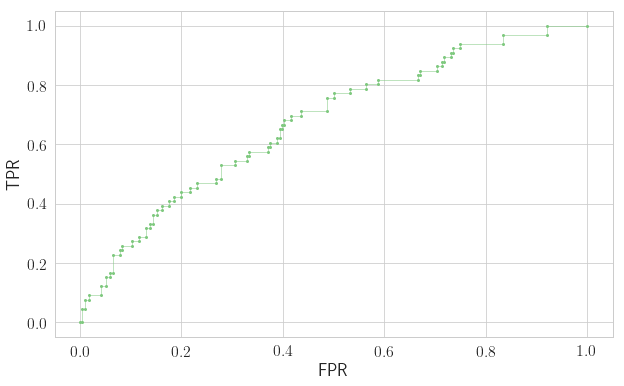

In [103]:
lrcv = linear_model.LogisticRegressionCV(cv=5, max_iter=650, penalty='l1', solver='saga',
                                         n_jobs=25, verbose=49)

lrcv.fit(X_train, y_train)

yhat = lrcv.predict_proba(X_test)

plotting.plotROC(y_test, yhat[:, 1])

lrcv.n_iter_

In [104]:
with open("../../allan_data/joachim_exercise_onehot_lr.pkl", 'bw') as fid:
    pickle.dump((lrcv, X_train, X_test, y_train, y_test), fid)

The binarized version fare badly... perhaps it's due to the large feature space.

## Try with resampling using SMOTE

In [205]:
lrcv = linear_model.LogisticRegressionCV(cv=5, max_iter=2500) 

In [206]:
smote = over_sampling.SMOTE(sampling_strategy='minority')

In [207]:
X_train, X_test, y_train, y_test = train_test_split(scale(df1.values.astype(float)), gender.values,
                                                    stratify=gender.values, test_size=0.3) 

X_train, y_train = smote.fit_resample(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=2500,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

AUC: 0.7742704826038159


(<matplotlib.figure.Figure at 0x7faa29d3cc50>,
 0.7742704826038159)

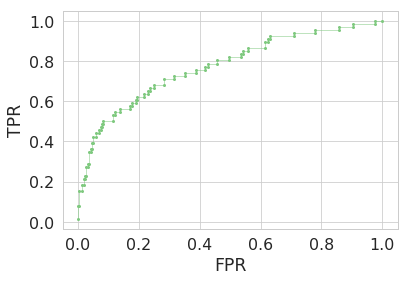

In [208]:
lrcv.fit(X_train, y_train)

yhat = lrcv.predict_proba(X_test)

plotting.plotROC(y_test, yhat[:, 1]) 

In [209]:
lrcv.n_iter_

array([[[ 9,  9, 11, 14, 19, 15, 13,  9,  2,  1],
        [10,  9, 11, 15, 19, 17, 13,  8,  2,  1],
        [ 9,  9, 11, 14, 16, 16, 12,  6,  1,  1],
        [10,  9, 11, 14, 17, 13, 12,  8,  1,  1],
        [10,  9, 11, 15, 16, 14, 11,  8,  1,  1]]], dtype=int32)

SMOTE doesn't work nearly as well... now try with the binarized data

In [217]:
X_train, X_test, y_train, y_test = train_test_split(dfd.values, gender.values,
                                                    stratify=gender.values, test_size=0.3) 

X_train, y_train = smote.fit_resample(X_train, y_train)

This runs so slowly that it was put into it's own file.

In [218]:
# lrcv.fit(X_train, y_train)

# yhat = lrcv.predict_proba(X_test)

# plotting.plotROC(y_test, yhat[:, 1])  

In [154]:
lrcv.n_iter_

array([[[  22,   17,   27,   69,  155,  276,  379,  479,  434,  404],
        [  21,   16,   24,   76,  163,  273,  503, 1064, 1338, 1538],
        [  21,   18,   32,   81,  146,  252,  381,  671,  878, 1053],
        [  22,   16,   30,   78,  140,  217,  370,  491,  956, 1508],
        [  20,   20,   38,   87,  154,  248,  422,  596,  825,  739]]],
      dtype=int32)

Thi binarized version actually fares better, but the effect of a larger feature space should be investigated.

### Use kNN

A real grid search with cross validation should be performed.

And ROC-curves shoud be created.

In [51]:
knn = neighbors.KNeighborsClassifier(p=4, n_neighbors=12)

In [52]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=12, p=4,
           weights='uniform')

In [53]:
accuracy_score(y_test, knn.predict(X_test))

0.76595744680851063

### Use some support vector machines

Train a support vector machines

In [54]:
clf = SVC(kernel='linear', C=1)
scores = cross_val_score(clf, X_train, y_train, cv=5)
scores

array([ 0.79545455,  0.81818182,  0.85606061,  0.76515152,  0.80769231])

In [55]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.81 (+/- 0.06)


Not a bad accuracy, but let's do a real grid search for parameter optimization.

Supress warnings about invalied measure due to category with 0 results

In [56]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

In [57]:
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, train_test_split


In [52]:
tuned_parameters = [{'C': [0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2']}]
scores = ['precision_macro', 'recall_macro', 'accuracy']
print(tuned_parameters, scores)

[{'C': [0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2']}] ['precision_macro', 'recall_macro', 'accuracy']


In [53]:
tuned_parameters

[{'C': [0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2']}]

In [59]:
for score in scores:
    clf = GridSearchCV(linear_model.LogisticRegression(), param_grid=tuned_parameters,
                       scoring=score, n_jobs=75) 
    clf.fit(X_train, y_train)
    print(f"""----------------------------------------------------------------
    Best parameters set found on development set using {score} for evaluation:

    {clf.best_params_}

    Grid scores on development set:
    """)
    
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    
    print("""

    Detailed classification report:

    The model is trained on the full development set.
    The scores are computed on the full evaluation set.
    """)

    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()


----------------------------------------------------------------
    Best parameters set found on development set using precision_macro for evaluation:

    {'C': 0.1, 'penalty': 'l1'}

    Grid scores on development set:
    
0.383 (+/-0.002) for {'C': 0.01, 'penalty': 'l1'}
0.760 (+/-0.087) for {'C': 0.01, 'penalty': 'l2'}
0.780 (+/-0.126) for {'C': 0.1, 'penalty': 'l1'}
0.740 (+/-0.087) for {'C': 0.1, 'penalty': 'l2'}
0.731 (+/-0.116) for {'C': 1, 'penalty': 'l1'}
0.698 (+/-0.104) for {'C': 1, 'penalty': 'l2'}
0.695 (+/-0.104) for {'C': 10, 'penalty': 'l1'}
0.691 (+/-0.094) for {'C': 10, 'penalty': 'l2'}
0.689 (+/-0.099) for {'C': 100, 'penalty': 'l1'}
0.689 (+/-0.099) for {'C': 100, 'penalty': 'l2'}
0.689 (+/-0.099) for {'C': 1000, 'penalty': 'l1'}
0.689 (+/-0.099) for {'C': 1000, 'penalty': 'l2'}


    Detailed classification report:

    The model is trained on the full development set.
    The scores are computed on the full evaluation set.
    
             precision    recall 

Train a model on the training dataset

In [60]:
lr = linear_model.LogisticRegression(**clf.best_params_)
lr.fit(X_train, y_train) 

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Predict on the entire dataset

AUC: 0.4566287878787879
Accuracy: 0.698936170213


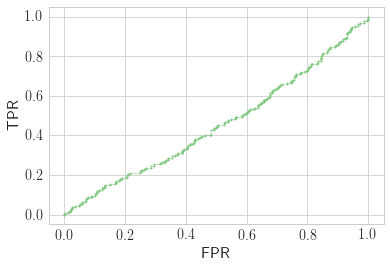

In [61]:
fig, ax, aucscore = plotting.plotROC(gender.values, lr.predict_proba(td1)[:, 1]) 
fig.savefig('figs/logistic_regression_fit_train_data_predict_all_data_roc_curve.pdf')
print("Accuracy:", accuracy_score(gender.values, lr.predict_proba(td1)[:,1]>0.5) )

Predict on the training dataset

AUC: 0.8341836734693878
Accuracy: 0.844984802432


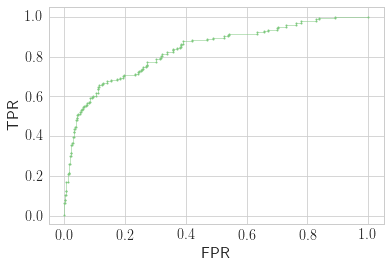

In [62]:
fig, ax, aucscore = plotting.plotROC(y_train, lr.predict_proba(X_train)[:, 1])
fig.savefig('figs/logistic_regression_fit_train_data_predict_train_data_roc_curve.pdf') 
print("Accuracy:", accuracy_score(y_train, lr.predict_proba(X_train)[:,1]>0.5) )

Predict on the test dataset

AUC: 0.8411195286195287
Accuracy: 0.81914893617


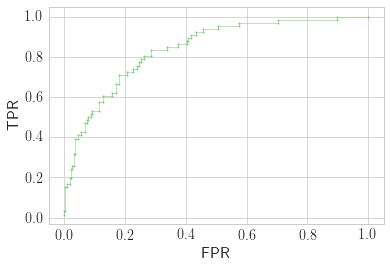

In [63]:
fig, ax, aucscore = plotting.plotROC(y_test, lr.predict_proba(X_test)[:, 1])
fig.savefig('figs/logistic_regression_fit_train_data_predict_test_data_roc_curve.pdf')
print("Accuracy:", accuracy_score(y_test, lr.predict_proba(X_test)[:,1]>0.5) )

Fit to the entire dataset

In [64]:
lr = linear_model.LogisticRegression(**clf.best_params_)
lr.fit(td1, gender.values) 

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Predict on the entire dataset

AUC: 0.8450189393939394
Accuracy: 0.842553191489


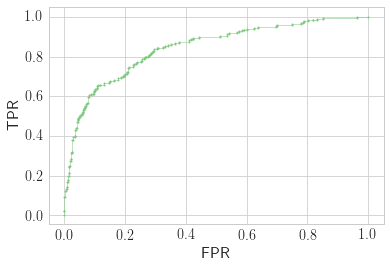

In [65]:
fig, ax, aucscore = plotting.plotROC(gender.values, lr.predict_proba(td1)[:, 1]) 
fig.savefig('figs/logistic_regression_fit_all_data_predict_all_data_roc_curve.pdf')
print("Accuracy:", accuracy_score(gender.values, lr.predict_proba(td1)[:,1]>0.5) )

Predict on the training dataset

AUC: 0.4771181199752628
Accuracy: 0.732522796353


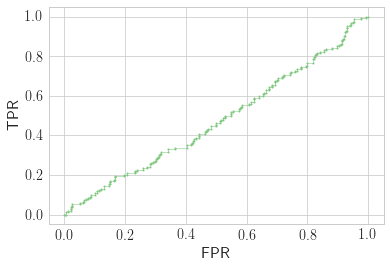

In [66]:
fig, ax, aucscore = plotting.plotROC(y_train, lr.predict_proba(X_train)[:, 1])
fig.savefig('figs/logistic_regression_fit_all_data_predict_train_data_roc_curve.pdf') 
print("Accuracy:", accuracy_score(y_train, lr.predict_proba(X_train)[:,1]>0.5) )

Predict on the test dataset

AUC: 0.597783389450056
Accuracy: 0.762411347518


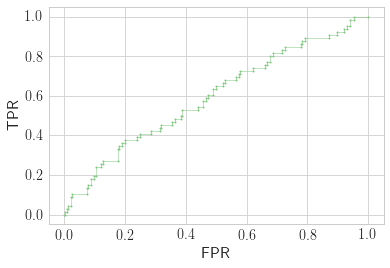

In [67]:
fig, ax, aucscore = plotting.plotROC(y_test, lr.predict_proba(X_test)[:, 1])
fig.savefig('figs/logistic_regression_fit_all_data_predict_test_data_roc_curve.pdf')
print("Accuracy:", accuracy_score(y_test, lr.predict_proba(X_test)[:,1]>0.5) )

In [87]:
tuned_parameters = [{'kernel': ['rbf', 'linear', 'poly'],
                     'gamma': [1e-2, 1e-2, 1e-3, 1e-4, 1e-5],
                     'C': [0.1, 1, 10, 100, 1000]}]
scores = ['precision_macro', 'recall_macro', 'accuracy']
print(tuned_parameters, scores)

[{'kernel': ['rbf', 'linear', 'poly'], 'gamma': [0.01, 0.01, 0.001, 0.0001, 1e-05], 'C': [0.1, 1, 10, 100, 1000]}] ['precision_macro', 'recall_macro', 'accuracy']


In [88]:
svc_best_params_list = list()
for score in scores:
    clf = GridSearchCV(SVC(), param_grid=tuned_parameters, scoring=score, n_jobs=75)
    clf.fit(X_train, y_train)
    print(f"""----------------------------------------------------------------
    Best parameters set found on development set using {score} for evaluation:

    {clf.best_params_}

    Grid scores on development set:
    """)

    svc_best_params_list.append((score, clf.best_params_))

#    means = clf.cv_results_['mean_test_score']
#    stds = clf.cv_results_['std_test_score']
#    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
#
    print("""

    Detailed classification report:

    The model is trained on the full development set.
    The scores are computed on the full evaluation set.
    """)

    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

----------------------------------------------------------------
    Best parameters set found on development set using precision_macro for evaluation:

    {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}

    Grid scores on development set:
    


    Detailed classification report:

    The model is trained on the full development set.
    The scores are computed on the full evaluation set.
    
             precision    recall  f1-score   support

          0       0.81      0.96      0.88       216
          1       0.67      0.24      0.36        66

avg / total       0.77      0.79      0.76       282


----------------------------------------------------------------
    Best parameters set found on development set using recall_macro for evaluation:

    {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

    Grid scores on development set:
    


    Detailed classification report:

    The model is trained on the full development set.
    The scores are computed on the full evaluation set.
   

'AUC: 0.8974180581323438'

Accuracy for SCORE: precision macro, TRAIN: train, TEST: train, ACCURACY: 0.8799392097264438
{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}


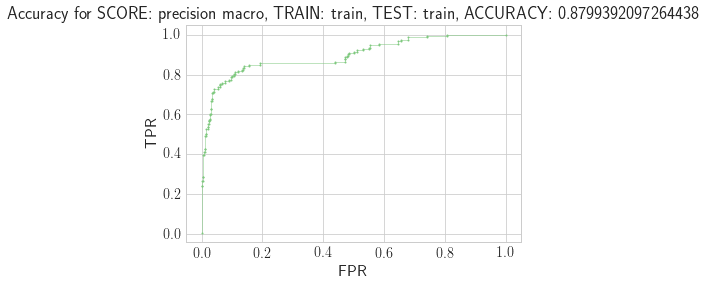

'AUC: 0.8127455106621774'

Accuracy for SCORE: precision macro, TRAIN: train, TEST: test, ACCURACY: 0.8156028368794326
{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}


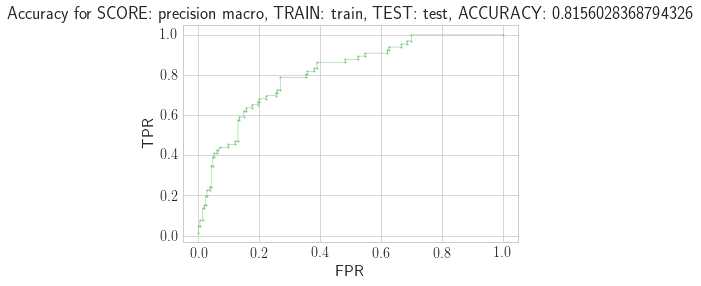

'AUC: 0.8774747474747475'

Accuracy for SCORE: precision macro, TRAIN: train, TEST: all, ACCURACY: 0.8606382978723405
{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}


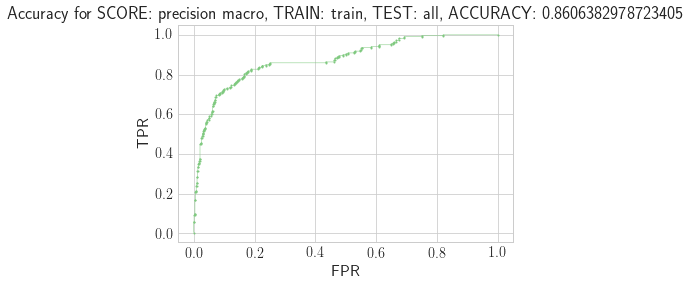

'AUC: 0.7906617192331477'

Accuracy for SCORE: precision macro, TRAIN: test, TEST: train, ACCURACY: 0.8024316109422492
{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}


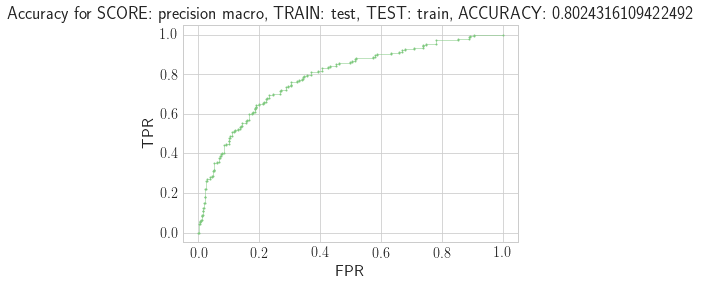

'AUC: 0.9492143658810326'

Accuracy for SCORE: precision macro, TRAIN: test, TEST: test, ACCURACY: 0.9042553191489362
{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}


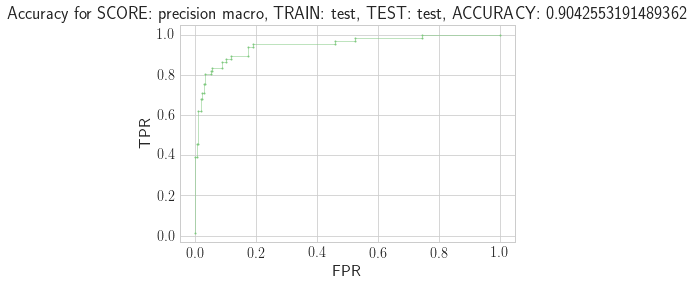

'AUC: 0.842689393939394'

Accuracy for SCORE: precision macro, TRAIN: test, TEST: all, ACCURACY: 0.8329787234042553
{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}


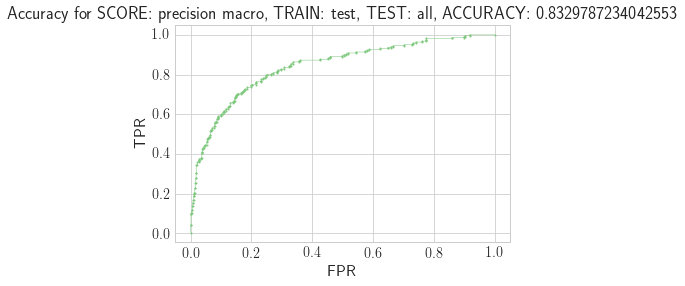

'AUC: 0.8916653782725212'

Accuracy for SCORE: precision macro, TRAIN: all, TEST: train, ACCURACY: 0.8662613981762918
{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}


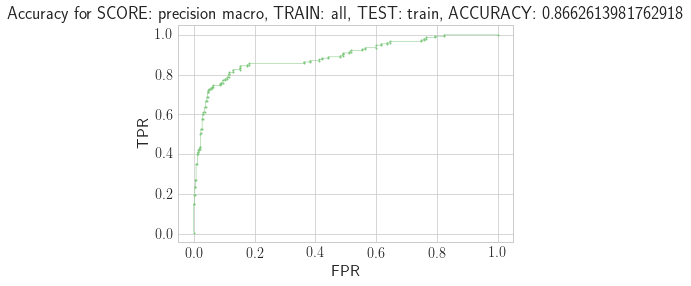

'AUC: 0.918841189674523'

Accuracy for SCORE: precision macro, TRAIN: all, TEST: test, ACCURACY: 0.8723404255319149
{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}


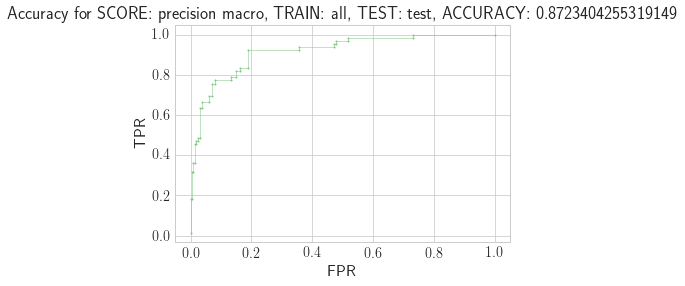

'AUC: 0.8998011363636363'

Accuracy for SCORE: precision macro, TRAIN: all, TEST: all, ACCURACY: 0.8680851063829788
{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}


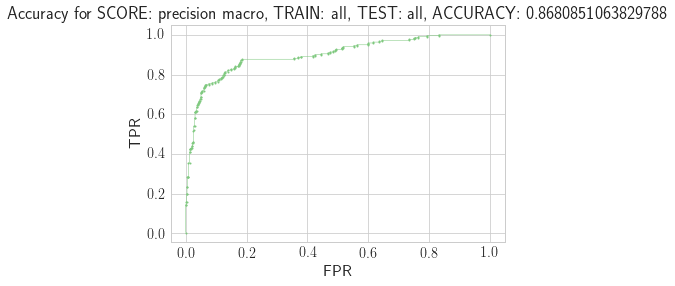

'AUC: 0.9915223665223666'

Accuracy for SCORE: recall macro, TRAIN: train, TEST: train, ACCURACY: 0.9513677811550152
{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


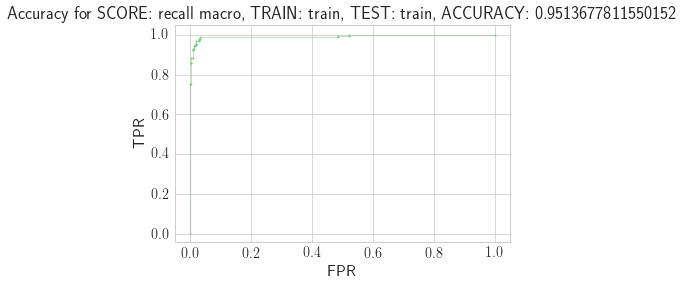

'AUC: 0.753226711560045'

Accuracy for SCORE: recall macro, TRAIN: train, TEST: test, ACCURACY: 0.7872340425531915
{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


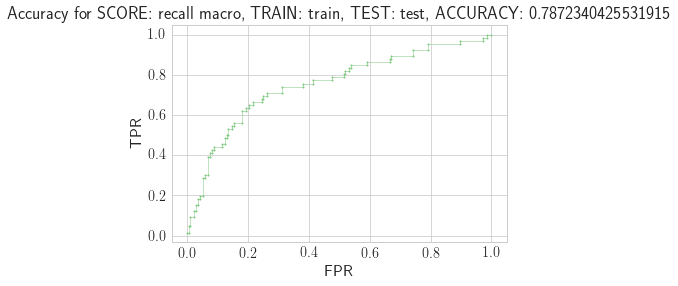

'AUC: 0.9298200757575757'

Accuracy for SCORE: recall macro, TRAIN: train, TEST: all, ACCURACY: 0.902127659574468
{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


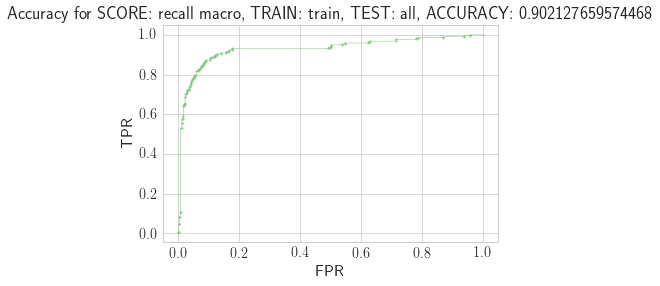

'AUC: 0.763682745825603'

Accuracy for SCORE: recall macro, TRAIN: test, TEST: train, ACCURACY: 0.78419452887538
{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


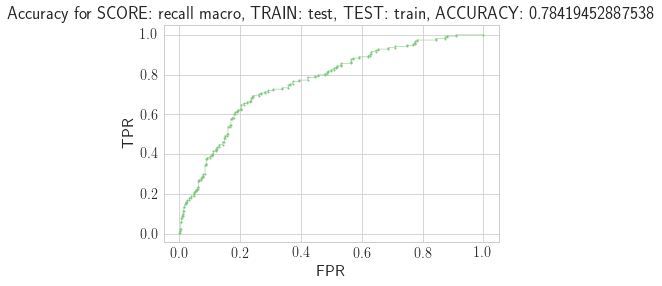

'AUC: 0.9995089786756454'

Accuracy for SCORE: recall macro, TRAIN: test, TEST: test, ACCURACY: 0.9609929078014184
{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


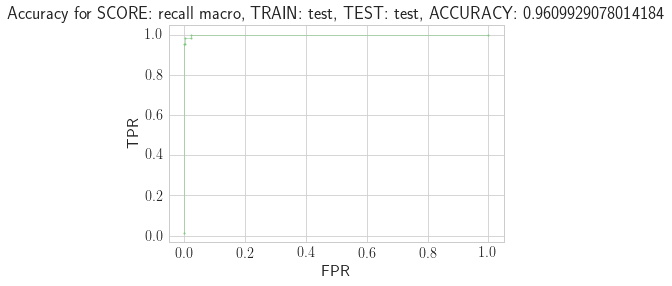

'AUC: 0.8493876262626262'

Accuracy for SCORE: recall macro, TRAIN: test, TEST: all, ACCURACY: 0.8372340425531914
{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


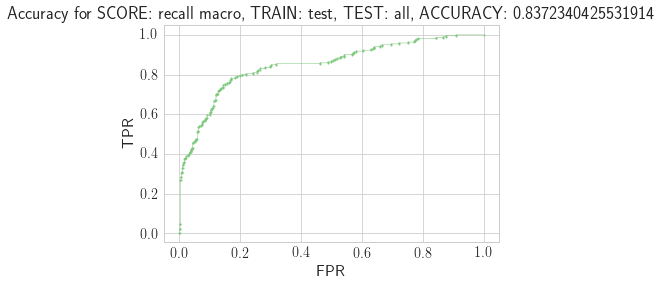

'AUC: 0.9884173366316223'

Accuracy for SCORE: recall macro, TRAIN: all, TEST: train, ACCURACY: 0.9437689969604863
{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


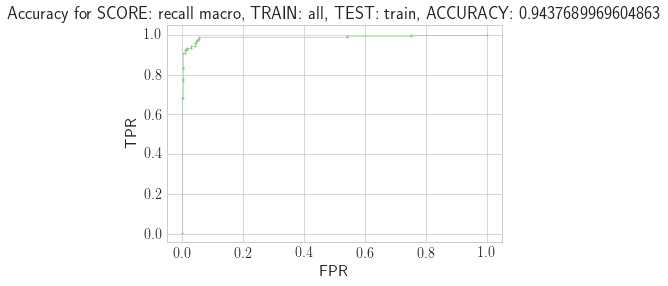

'AUC: 0.9870230078563411'

Accuracy for SCORE: recall macro, TRAIN: all, TEST: test, ACCURACY: 0.9468085106382979
{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


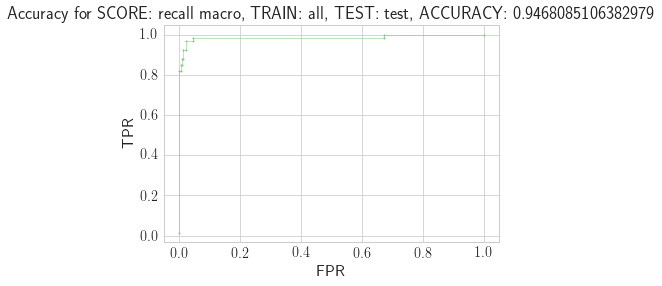

'AUC: 0.9877777777777776'

Accuracy for SCORE: recall macro, TRAIN: all, TEST: all, ACCURACY: 0.9446808510638298
{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


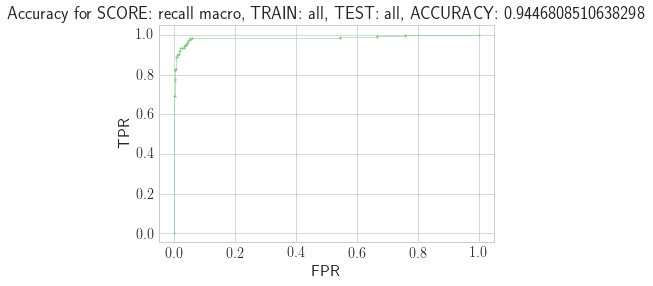

'AUC: 0.9915223665223666'

Accuracy for SCORE: accuracy, TRAIN: train, TEST: train, ACCURACY: 0.9513677811550152
{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


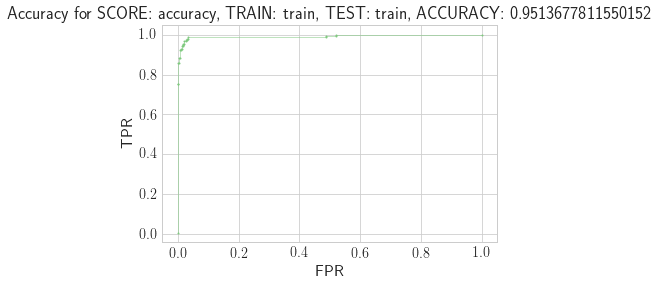

'AUC: 0.7532968574635241'

Accuracy for SCORE: accuracy, TRAIN: train, TEST: test, ACCURACY: 0.7872340425531915
{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


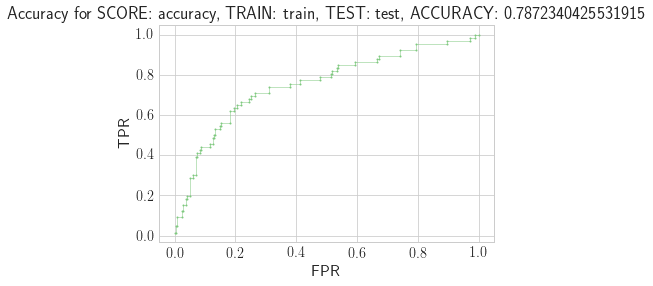

'AUC: 0.929832702020202'

Accuracy for SCORE: accuracy, TRAIN: train, TEST: all, ACCURACY: 0.902127659574468
{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


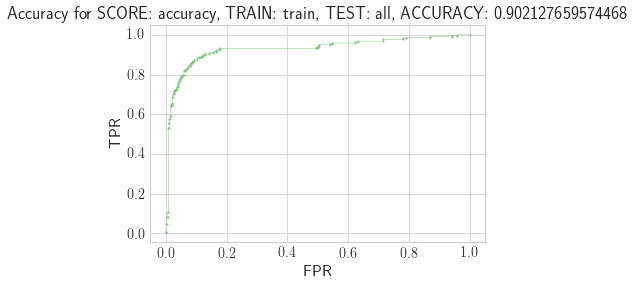

'AUC: 0.7636634199134199'

Accuracy for SCORE: accuracy, TRAIN: test, TEST: train, ACCURACY: 0.7796352583586627
{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


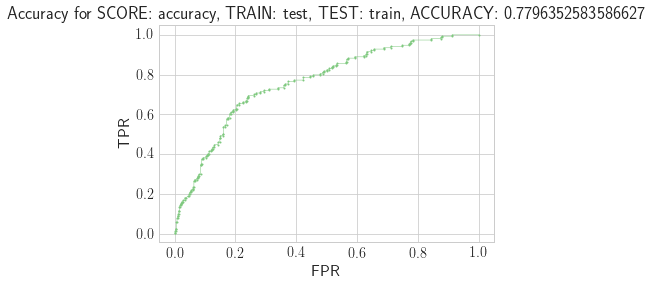

'AUC: 0.9995089786756454'

Accuracy for SCORE: accuracy, TRAIN: test, TEST: test, ACCURACY: 0.9716312056737588
{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


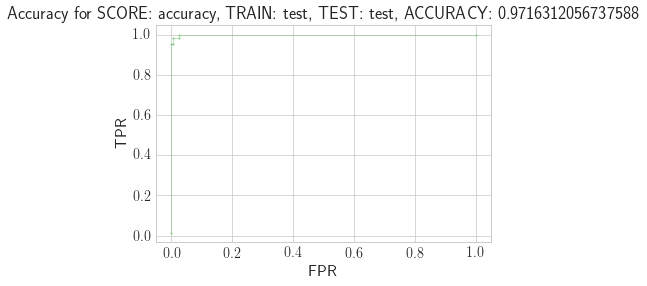

'AUC: 0.8493718434343435'

Accuracy for SCORE: accuracy, TRAIN: test, TEST: all, ACCURACY: 0.8372340425531914
{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


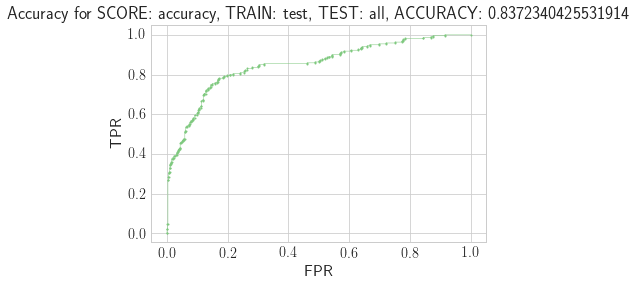

'AUC: 0.9884173366316223'

Accuracy for SCORE: accuracy, TRAIN: all, TEST: train, ACCURACY: 0.9437689969604863
{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


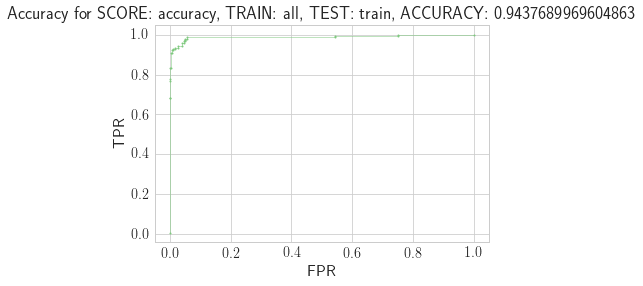

'AUC: 0.9870230078563411'

Accuracy for SCORE: accuracy, TRAIN: all, TEST: test, ACCURACY: 0.9468085106382979
{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


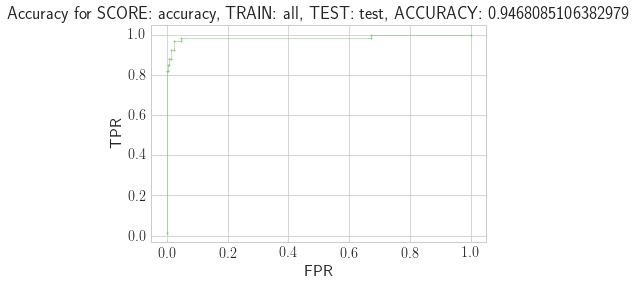

'AUC: 0.9877777777777776'

Accuracy for SCORE: accuracy, TRAIN: all, TEST: all, ACCURACY: 0.9446808510638298
{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


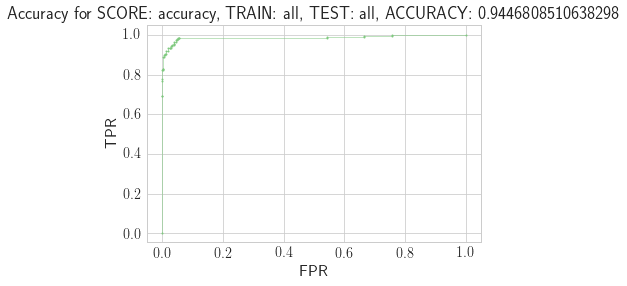

In [92]:
data_sets = [(X_train, y_train, 'train'),
             (X_test, y_test, 'test'),
             (nd1, gender.values, 'all')]

for score, best_params in svc_best_params_list:
    svc = SVC(**best_params, probability=True)
    for X_tr, y_tr, label_tr in data_sets:
        assert X_tr.shape[0] == y_tr.shape[0], f"Training shape mismatch X_tr.shape: {X_tr.shape} y_tr.shape: {y_tr.shape}"
        svc.fit(X_tr, y_tr)
        for X_pr, y_pr, label_pr in data_sets:
            assert X_tr.shape[0] == y_tr.shape[0], f"Prediction shape mismatch X_pr.shape: {X_pr.shape} y_pr.shape: {y_pr.shape}"
            svc_prediction = svc.predict_proba(X_pr)[:, 1]
            figname = f"svm {label_tr} data train {label_pr} data predict using score {score} with kernel {best_params['kernel']} roc_curve"
            fig, ax, aucscore = plotting.plotROC(y_pr, svc_prediction, auc_do=display)
            fig_title = f"Accuracy for SCORE: {score.replace('_', ' ')}, TRAIN: {label_tr}, TEST: {label_pr}, ACCURACY: {accuracy_score(y_pr, svc_prediction > 0.5)}"
            print(fig_title)
            print(best_params)
            fig.savefig(figname.replace(' ', '_') + '.pdf')
            ax.set_title(fig_title)
            display(fig)
            plt.close()
plt.ion() 

Do second cross validation, with a finer grid around the best parameters

In [102]:
n_steps = 20
score, best_params = svc_best_params_list[-1]
C_best = best_params['C']
gamma_best = best_params['gamma']
C_arr = np.linspace(C_best/(n_steps/2), C_best*(n_steps/2), n_steps)
gamma_arr = np.linspace(gamma_best/(n_steps/2), gamma_best*(n_steps/2), n_steps)
tuned_sub_parameters = [{'kernel': [best_params['kernel']],
                     'gamma': gamma_arr,
                     'C': C_arr}]
scores = [score]

In [103]:
svc_sub_best_params_list = list()
for score in scores:
    clf = GridSearchCV(SVC(), param_grid=tuned_sub_parameters, scoring=score, n_jobs=75)
    clf.fit(X_train, y_train)
    print(f"""----------------------------------------------------------------
    Best parameters set found on development set using {score} for evaluation:

    {clf.best_params_}

    Grid scores on development set:
    """)

    svc_sub_best_params_list.append((score, clf.best_params_))

#    means = clf.cv_results_['mean_test_score']
#    stds = clf.cv_results_['std_test_score']
#    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
#
    print("""

    Detailed classification report:

    The model is trained on the full development set.
    The scores are computed on the full evaluation set.
    """)

    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

----------------------------------------------------------------
    Best parameters set found on development set using accuracy for evaluation:

    {'C': 6.2105263157894735, 'gamma': 0.011421052631578946, 'kernel': 'rbf'}

    Grid scores on development set:
    


    Detailed classification report:

    The model is trained on the full development set.
    The scores are computed on the full evaluation set.
    
             precision    recall  f1-score   support

          0       0.84      0.89      0.86       216
          1       0.55      0.42      0.48        66

avg / total       0.77      0.78      0.77       282




In [182]:
auc_df = pd.DataFrame(index="all train test".split(), columns="all train test".split())
auc_df.index.name='training/testing'
acc_df = pd.DataFrame(index="all train test".split(), columns="all train test".split())
acc_df.index.name='training/testing'

'AUC: 0.980223149866007'

Accuracy for SCORE: accuracy, TRAIN: train, TEST: train, ACCURACY: 0.9452887537993921
{'C': 6.2105263157894735, 'gamma': 0.011421052631578946, 'kernel': 'rbf'}


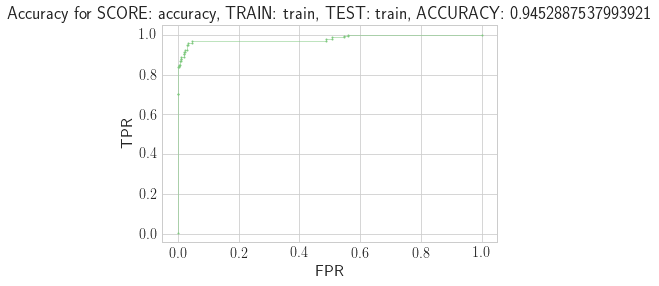

'AUC: 0.7648007856341189'

Accuracy for SCORE: accuracy, TRAIN: train, TEST: test, ACCURACY: 0.7943262411347518
{'C': 6.2105263157894735, 'gamma': 0.011421052631578946, 'kernel': 'rbf'}


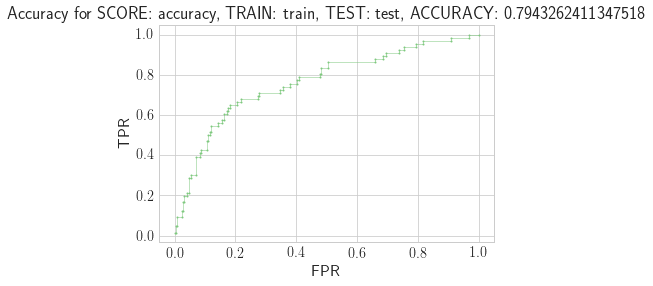

'AUC: 0.9266666666666666'

Accuracy for SCORE: accuracy, TRAIN: train, TEST: all, ACCURACY: 0.9
{'C': 6.2105263157894735, 'gamma': 0.011421052631578946, 'kernel': 'rbf'}


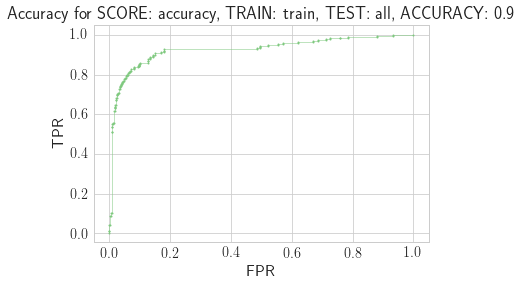

'AUC: 0.7695642650999794'

Accuracy for SCORE: accuracy, TRAIN: test, TEST: train, ACCURACY: 0.790273556231003
{'C': 6.2105263157894735, 'gamma': 0.011421052631578946, 'kernel': 'rbf'}


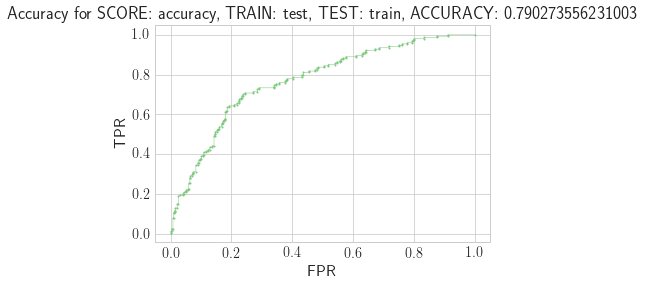

'AUC: 0.99172278338945'

Accuracy for SCORE: accuracy, TRAIN: test, TEST: test, ACCURACY: 0.9574468085106383
{'C': 6.2105263157894735, 'gamma': 0.011421052631578946, 'kernel': 'rbf'}


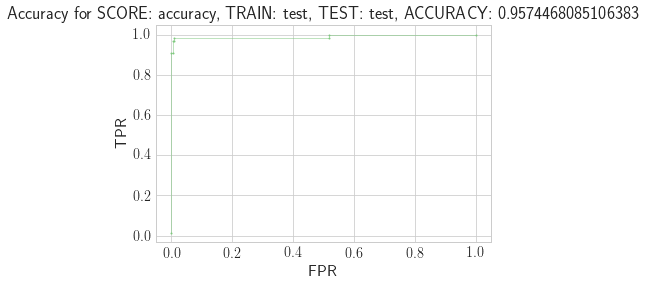

'AUC: 0.8530997474747475'

Accuracy for SCORE: accuracy, TRAIN: test, TEST: all, ACCURACY: 0.8404255319148937
{'C': 6.2105263157894735, 'gamma': 0.011421052631578946, 'kernel': 'rbf'}


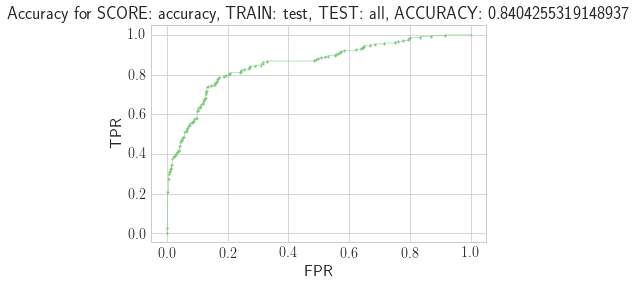

'AUC: 0.9777107812822098'

Accuracy for SCORE: accuracy, TRAIN: all, TEST: train, ACCURACY: 0.9346504559270516
{'C': 6.2105263157894735, 'gamma': 0.011421052631578946, 'kernel': 'rbf'}


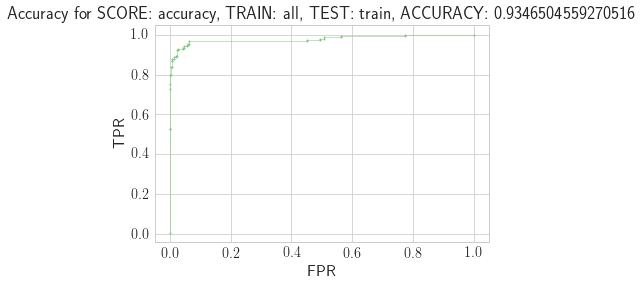

'AUC: 0.9829545454545455'

Accuracy for SCORE: accuracy, TRAIN: all, TEST: test, ACCURACY: 0.9432624113475178
{'C': 6.2105263157894735, 'gamma': 0.011421052631578946, 'kernel': 'rbf'}


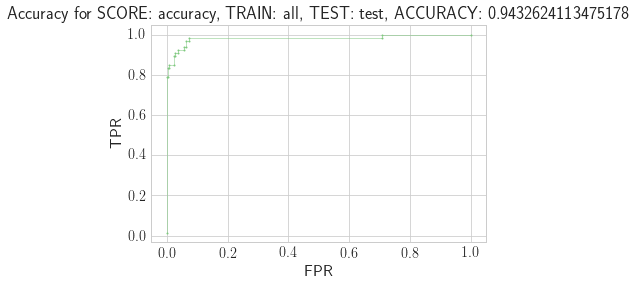

'AUC: 0.9793308080808081'

Accuracy for SCORE: accuracy, TRAIN: all, TEST: all, ACCURACY: 0.9372340425531915
{'C': 6.2105263157894735, 'gamma': 0.011421052631578946, 'kernel': 'rbf'}


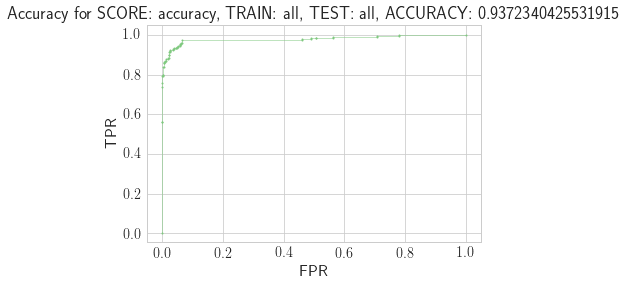

In [186]:
data_sets = [(X_train, y_train, 'train'),
             (X_test, y_test, 'test'),
             (nd1, gender.values, 'all')]

for score, best_params in svc_sub_best_params_list:
    svc = SVC(**best_params, probability=True)
    for X_tr, y_tr, label_tr in data_sets:
        assert X_tr.shape[0] == y_tr.shape[0], f"Training shape mismatch X_tr.shape: {X_tr.shape} y_tr.shape: {y_tr.shape}"
        svc.fit(X_tr, y_tr)
        for X_pr, y_pr, label_pr in data_sets:
            assert X_tr.shape[0] == y_tr.shape[0], f"Prediction shape mismatch X_pr.shape: {X_pr.shape} y_pr.shape: {y_pr.shape}"
            svc_prediction = svc.predict_proba(X_pr)[:, 1]
            figname = f"svm {label_tr} data train {label_pr} data predict using score {score} with kernel {best_params['kernel']} subfit roc_curve"
            fig, ax, aucscore = plotting.plotROC(y_pr, svc_prediction, auc_do=display)
            fold_accuracy = accuracy_score(y_pr, svc_prediction > 0.5) 
            fig_title = f"Accuracy for SCORE: {score.replace('_', ' ')}, TRAIN: {label_tr}, TEST: {label_pr}, ACCURACY: {fold_accuracy}"
            print(fig_title)
            print(best_params)
            auc_df.loc[label_tr, label_pr] = aucscore
            acc_df.loc[label_tr, label_pr] = fold_accuracy
            fig.savefig(figname.replace(' ', '_') + '.pdf')
            ax.set_title(fig_title)
            display(fig)
            plt.close()
plt.ion() 

In [188]:
auc_df

,all,train,test
training data,,,
all,0.979331,0.977711,0.982955
train,0.926667,0.980223,0.764801
test,0.8531,0.769564,0.991723


In [189]:
acc_df

,all,train,test
training data,,,
all,0.937234,0.93465,0.943262
train,0.9,0.945289,0.794326
test,0.840426,0.790274,0.957447


In [195]:
from tabulate import tabulate

print(tabulate(auc_df, headers='keys', tablefmt='pipe'), end='\n\n')
print(tabulate(acc_df, headers='keys', tablefmt='pipe'))

| training/testing   |      all |    train |     test |
|:-------------------|---------:|---------:|---------:|
| all                | 0.979331 | 0.977711 | 0.982955 |
| train              | 0.926667 | 0.980223 | 0.764801 |
| test               | 0.8531   | 0.769564 | 0.991723 |

| training/testing   |      all |    train |     test |
|:-------------------|---------:|---------:|---------:|
| all                | 0.937234 | 0.93465  | 0.943262 |
| train              | 0.9      | 0.945289 | 0.794326 |
| test               | 0.840426 | 0.790274 | 0.957447 |


Evalueate model performance using stratified shuffle split

'AUC: 0.7134189113355778'

Accuracy for SCORE: accuracy, TRAIN: all, TEST: all, ACCURACY: 0.7872340425531915
{'C': 6.2105263157894735, 'gamma': 0.011421052631578946, 'kernel': 'rbf'}


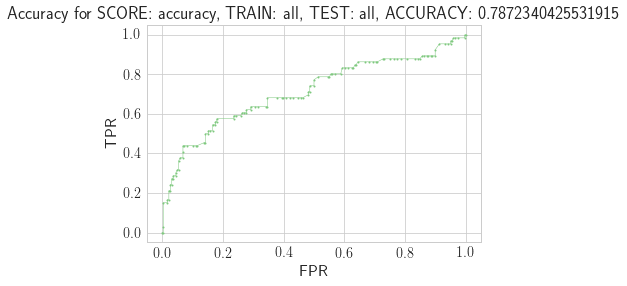

'AUC: 0.6860620089786756'

Accuracy for SCORE: accuracy, TRAIN: all, TEST: all, ACCURACY: 0.7659574468085106
{'C': 6.2105263157894735, 'gamma': 0.011421052631578946, 'kernel': 'rbf'}


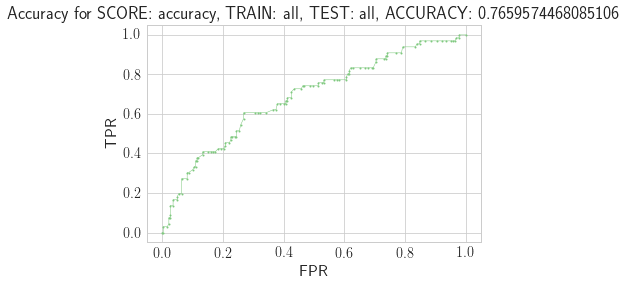

'AUC: 0.703037317620651'

Accuracy for SCORE: accuracy, TRAIN: all, TEST: all, ACCURACY: 0.776595744680851
{'C': 6.2105263157894735, 'gamma': 0.011421052631578946, 'kernel': 'rbf'}


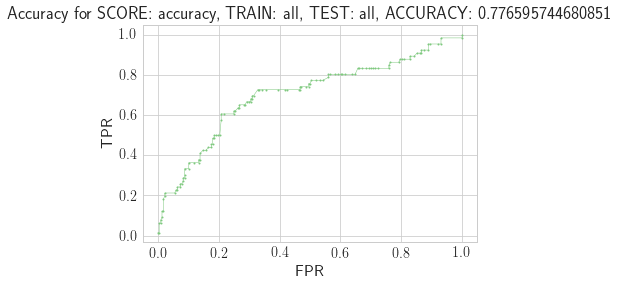

'AUC: 0.7276234567901235'

Accuracy for SCORE: accuracy, TRAIN: all, TEST: all, ACCURACY: 0.7730496453900709
{'C': 6.2105263157894735, 'gamma': 0.011421052631578946, 'kernel': 'rbf'}


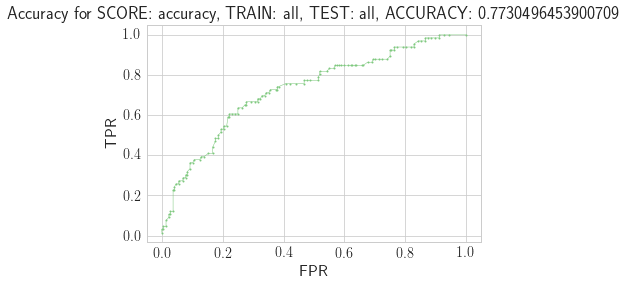

'AUC: 0.6845538720538721'

Accuracy for SCORE: accuracy, TRAIN: all, TEST: all, ACCURACY: 0.7695035460992907
{'C': 6.2105263157894735, 'gamma': 0.011421052631578946, 'kernel': 'rbf'}


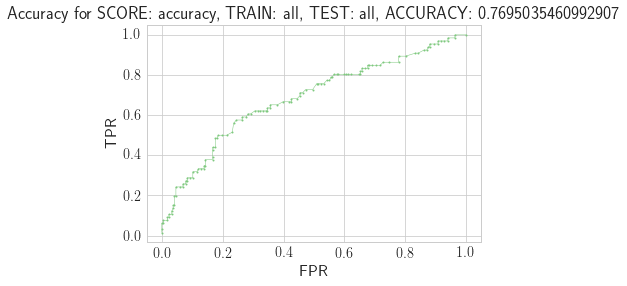

In [178]:
perf_df = pd.DataFrame(index="all train test".split(), columns="all train test".split())
plt.ioff()
n_splits = 5
x = nd1
y = gender.values
sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.3, random_state=0)
sss.get_n_splits(x, y)
svc = SVC(**best_params, probability=True)
accuracies_arr = np.zeros(n_splits)
auc_arr = np.zeros(n_splits)
for i, (train_index, test_index) in enumerate(sss.split(X, y)):
    X_tr, X_te = X[train_index], X[test_index]
    y_tr, y_te = y[train_index], y[test_index]
    svc.fit(X_tr, y_tr)
    assert X_tr.shape[0] == y_tr.shape[0], f"Prediction shape mismatch X_pr.shape: {X_pr.shape} y_pr.shape: {y_pr.shape}"
    svc_prediction = svc.predict_proba(X_te)[:, 1]
    figname = f"svm {label_tr} data train {label_pr} data predict using score {score} with kernel {best_params['kernel']} fold {i} roc_curve"
    fig, ax, aucscore = plotting.plotROC(y_te, svc_prediction, auc_do=display)
    fold_accuracy = accuracy_score(y_te, svc_prediction > 0.5)
    accuracies_arr[i] = fold_accuracy
    auc_arr[i] = aucscore
    fig_title = f"Accuracy for SCORE: {score}, TRAIN: {label_tr}, TEST: {label_pr}, ACCURACY: {fold_accuracy}"
    print(fig_title)
    print(best_params)
    fig.savefig(figname.replace(' ', '_') + '.pdf')
    ax.set_title(fig_title)
    display(fig)
    plt.close()
plt.ion()

In [113]:
print("Accuracy =", accuracies_arr.mean(), '±', accuracies_arr.std())
print("AUC =", auc_arr.mean(), '±', auc_arr.std())

Accuracy = 0.783687943262 ± 0.0107558516937
AUC = 0.702925084175 ± 0.0163723514034


## Use new functions to grid search cross validate and gauge performance by cross validation

In [54]:
pdf_svc = stratifiedCrossEval(nd1, gender.values, lr, n_splits=30, test_size=0.2)

Check performance again, but without plots and using LeavePOut method

In [166]:
try:
    pool.close()
except:
    print("Didn't close pool")
    pass

pool = Pool(72)

def pool_mapping_function(i, X_tr, y_tr, X_te, y_te):
    svc.fit(X_tr, y_tr)
    svc_prediction = svc.predict_proba(X_te)[:, 1]
    fold_accuracy = accuracy_score(y_te, svc_prediction > 0.5)
    if i % 80 == 0:
        print(i, 'done!')
    return fold_accuracy

lpo = LeavePOut(p=1)
print(lpo.get_n_splits(x), "splits")
svc = SVC(**best_params, probability=True)
accuracies_arr = np.zeros(lpo.get_n_splits(x))
try:
    to_map_args = list()
    for i, (train_index, test_index) in enumerate(lpo.split(X)):
        X_tr, X_te = X[train_index], X[test_index]
        y_tr, y_te = y[train_index], y[test_index]
        to_map_args.append((i, X_tr, y_tr, X_te, y_te))
        if i % 80 == 0:
            print("{:0.2f} % ".format(i/lpo.get_n_splits(x)*100))
    print("Doing computation")
    res = pool.starmap(pool_mapping_function, to_map_args)
except Exception as err:
    print(err)
    pool.close()
finally:
    pool.close()
pool.close()

In [173]:
accuracies_arr = np.array(res)
print("Accuracy =", accuracies_arr.mean(), '±', accuracies_arr.std(), '    (mean ± std)')

Accuracy = 0.774468085106 ± 0.417932135948     (mean ± std)


This result is way worse!

In [ ]:
tuned_parameters = [dict(n_estimators=np.ceil(2**np.linspace(1, 8, 10)).astype(int),
                         max_depth=[3, 5, 8, 12, 16, 25])]

print(tuned_parameters)

In [ ]:
for score in scores:
    clf = GridSearchCV(RandomForestClassifier(), param_grid=tuned_parameters, scoring=score, n_jobs=75) 
    clf.fit(X_train, y_train)
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()
    
    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

In [ ]:
clf.best_estimator_

In [ ]:
fig, ax, aucscore = plotting.plotROC(gender.values, clf.best_estimator_.predict_proba(td1)[:, 1])
fig.savefig('figs/random_forrest_all_data_roc_curve.pdf')

In [ ]:
fig, ax, aucscore = plotting.plotROC(y_train, clf.best_estimator_.predict_proba(X_train)[:, 1])
fig.savefig('figs/random_forrest_training_data_roc_curve.pdf')

In [ ]:
fig, ax, aucscore = plotting.plotROC(y_test, clf.best_estimator_.predict_proba(X_test)[:, 1])
fig.savefig('figs/random_forrest_test_data_roc_curve.pdf')